# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary points structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and reorientation the subset of such points (`outputSet`) that lie on the convex hull.

In [36]:
# TODO: make sure to mention space complexity in report
# TODO: insertion sort is notably faster than quicksort and mergesort for small arrays, so it may be worth using it for small subhulls in Chan.
# TODO: add unit of time in experimental framework

In [37]:
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# Utilities

class Point2D:
    x: float
    y: float
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __lt__(self, other: 'Point2D') -> bool:
        return self.x < other.x or (self.x == other.x and self.y < other.y)

    def __eq__(self, other: 'Point2D') -> bool:
        return self.x == other.x and self.y == other.y

    def __repr__(self) -> str:
        return f"({self.x}, {self.y})"
    
def distance_squared(p1: Point2D, p2: Point2D) -> float:
    return (p1.x - p2.x)**2 + (p1.y - p2.y)**2

def polar_angle(p0: Point2D, p: Point2D) -> float:
    return math.atan2(p.y - p0.y, p.x - p0.x)

def leftmost_point(points: list[Point2D]) -> Point2D:
     # Return the point with the smallest x (and smallest y if necessary)
    return min(points)

def copy_points(points: list[Point2D]) -> list[Point2D]:
    return [point for point in points]

CLOCKWISE = 1
ANTI_CLOCKWISE = -1
COLINEAR = 0
def orientation(p: Point2D, q: Point2D, r: Point2D) -> int:
    cross_product = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)

    if cross_product == 0:
        return COLINEAR
    return CLOCKWISE if cross_product > 0 else ANTI_CLOCKWISE

def plot_points(input_set: list[Point2D], output_set: list[Point2D]):
    xs = [p.x for p in input_set]
    ys = [p.y for p in input_set]
    plt.scatter(xs, ys, color='blue')  # Set the color of input points to blue
    xs = [p.x for p in output_set]
    ys = [p.y for p in output_set]
    # close the loop
    xs.append(output_set[0].x)
    ys.append(output_set[0].y)
    # Set the color of hull points to red with red lines and dots
    plt.plot(xs, ys, color='red', linestyle='-', marker='o')
    plt.show()

In [38]:
# Sorting functions

GREATER_THAN = 1
EQUAL = 0
LESS_THAN = -1
def compare(p0: Point2D, p1: Point2D, p2: Point2D) -> int:
    # all relative to p0

    # first compare by angle
    angle1 = polar_angle(p0, p1)
    angle2 = polar_angle(p0, p2)

    # tolerance of 1e-9 (to avoid floating point inaccuracies)
    if abs(angle1 - angle2) > 1e-9:
        return LESS_THAN if angle1 < angle2 else GREATER_THAN

    # if angles are equal, compare by distance_squared_squared
    sq_dist1 = distance_squared(p0, p1)
    sq_dist2 = distance_squared(p0, p2)

    if sq_dist1 < sq_dist2:
        return LESS_THAN
    if sq_dist1 > sq_dist2:
        return GREATER_THAN

    return EQUAL

def quick_sort(points: list[Point2D], p0: Point2D) -> list[Point2D]:
    def partition(points: list[Point2D], low: int, high: int) -> int:
        pivot = points[high]  
        i = low - 1 

        for j in range(low, high):
            if compare(p0, points[j], pivot) <= 0: # angle with points[j] is less than or equal to angle with pivot
                i += 1
                points[i], points[j] = points[j], points[i]

        points[i + 1], points[high] = points[high], points[i + 1]
        return i + 1

    def _quick_sort(points: list[Point2D], low: int, high: int):
        if low < high:
            pivot_index = partition(points, low, high)
            _quick_sort(points, low, pivot_index - 1)
            _quick_sort(points, pivot_index + 1, high)
        
    _quick_sort(points, 0, len(points) - 1)
    return points  
    
def merge_sort(points: list[Point2D], p0: Point2D) -> list[Point2D]:
    def merge(left: list[Point2D], right: list[Point2D]) -> list[Point2D]:
        result = []
        while left and right:
            if compare(p0, left[0], right[0]) <= 0: # angle with left[0] is less than or equal to angle with right[0]
                result.append(left.pop(0))
            else:
                result.append(right.pop(0))
        result.extend(left or right)
        return result
   
    if len(points) > 1:
        mid = len(points) // 2
        left = merge_sort(points[:mid], p0)
        right = merge_sort(points[mid:], p0)
        return merge(left, right)
    else:
        return points
    
def heap_sort(points: list[Point2D], p0: Point2D) -> list[Point2D]:
    def heapify(points: list[Point2D], n: int, i: int):
        """
        Builds a max-heap from an array.

        Args:
            points: The array to be heapified.
            n: The size of the heap.
            i: The index of the parent node.
        """
        largest = i  # Initialize the index of the largest element as the root
        l = 2 * i + 1  # Index of the left child
        r = 2 * i + 2  # Index of the right child

        # Compare with the left child (if within bounds)
        if l < n and compare(p0, points[l], points[largest]) > 0:
            largest = l

        # Compare with the right child (if within bounds)
        if r < n and compare(p0, points[r], points[largest]) > 0:
            largest = r

        # If the root was not the largest, swap and recursively heapify
        if largest != i:
            points[i], points[largest] = points[largest], points[i]
            heapify(points, n, largest)

    def _heap_sort(points: list[Point2D]):
        """Performs heap sort on the given array."""
        n = len(points)

        # Build the max-heap
        for i in range(n // 2 - 1, -1, -1):
            heapify(points, n, i)

        # Extract elements one by one by swapping the root with the end and heapifying
        for i in range(n - 1, 0, -1):
            points[i], points[0] = points[0], points[i]
            heapify(points, i, 0)

    _heap_sort(points)
    return points


def sorted_by_polar_angle(
        p0: Point2D,
        input_set: list[Point2D],
        sorting_algorithm: callable
    ) -> list[Point2D]:
    return sorting_algorithm(input_set, p0)

In [39]:
def jarvis_march(input_set: list[Point2D]) -> list[Point2D]:
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # Start with the leftmost point
    point_on_hull = leftmost_point(input_set)
    convex_hull = [] 

    while True:
        convex_hull.append(point_on_hull)
        # Start with the first point as the endpoint of the segment from point_on_hull
        end_point = input_set[0]

        for j in range(0, len(input_set)):
            # Check against all other points
            dir = orientation(convex_hull[-1], end_point, input_set[j])
            if (
                end_point == point_on_hull or 
                dir == ANTI_CLOCKWISE or
                (dir == COLINEAR and 
                    distance_squared(convex_hull[-1], input_set[j]) > distance_squared(convex_hull[-1], end_point)
                )
            ):  
                # Found a more counterclockwise point
                end_point = input_set[j]

        point_on_hull = end_point

        # check if we have wrapped around to the first point
        if end_point == convex_hull[0]:
            break

    return convex_hull

In [40]:
def jarvis_march_terminate(input_set: list[Point2D], m: int) -> list[Point2D]:
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # Start with the leftmost point
    point_on_hull = leftmost_point(input_set)
    convex_hull = [] 

    for _ in range(m):
        convex_hull.append(point_on_hull)
        # Start with the first point as the endpoint of the segment from point_on_hull
        end_point = input_set[0]

        for j in range(0, len(input_set)):
            # Check against all other points
            dir = orientation(convex_hull[-1], end_point, input_set[j])
            if (
                end_point == point_on_hull or 
                dir == ANTI_CLOCKWISE or
                (dir == COLINEAR and 
                    distance_squared(convex_hull[-1], input_set[j]) > distance_squared(convex_hull[-1], end_point)
                )
            ):  
                # Found a more counterclockwise point
                end_point = input_set[j]

        point_on_hull = end_point

        # check if we have wrapped around to the first point
        if end_point == convex_hull[0]:
            return convex_hull
    return None


Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [41]:
def graham_scan(
        input_set: list[Point2D],
        sorting_algorithm = merge_sort # default sorting algorithm 
    ) -> list[Point2D]:
    """
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    if len(input_set) < 3:
        return input_set

    p0 = min(input_set, key=lambda p: (p.y, p.x))
    convex_hull = []
    input_set = sorted_by_polar_angle(p0, input_set, sorting_algorithm)
    for i in range(len(input_set)):
        while (
            len(convex_hull) > 1 and
            orientation(convex_hull[-2], convex_hull[-1], input_set[i]) != ANTI_CLOCKWISE
        ):
            convex_hull.pop()
        convex_hull.append(input_set[i])
    return convex_hull

def graham_scan_quick_sort(input_set: list[Point2D]) -> list[Point2D]:
    return graham_scan(input_set, quick_sort)

def graham_scan_merge_sort(input_set: list[Point2D]) -> list[Point2D]:
    return graham_scan(input_set, merge_sort)

def graham_scan_heap_sort(input_set: list[Point2D]) -> list[Point2D]:
    return graham_scan(input_set, heap_sort)

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [42]:
def partition_points(input_set: list[Point2D], partition_size: int) -> list[list[Point2D]]: 
    return [input_set[i:i + partition_size] for i in range(0, len(input_set), partition_size)]

def right_tangent(p: Point2D, hull: list[Point2D]) -> int:
    """Returns the index of the right tangent of a point p to a convex hull."""
    if len(hull) == 1:
        return 0
    
    left, right   = 0, len(hull) - 1
    left_prev_dir = orientation(p, hull[0], hull[-1])
    left_next_dir = orientation(p, hull[0], hull[(left + 1) % right])
    while left < right:
        mid = (left + right) // 2
        mid_prev_dir = orientation(p, hull[mid], hull[abs(mid - 1) % len(hull)])
        mid_next_dir = orientation(p, hull[mid], hull[(mid + 1) % len(hull)])
        mid_side_dir = orientation(p, hull[left],   hull[mid])
        if mid_prev_dir != ANTI_CLOCKWISE and mid_next_dir != ANTI_CLOCKWISE:
            # tangent touches mid -> found
            return mid
        elif mid_side_dir == CLOCKWISE and (left_next_dir == ANTI_CLOCKWISE or
                                      left_prev_dir == left_next_dir) or \
                mid_side_dir == ANTI_CLOCKWISE and mid_prev_dir == ANTI_CLOCKWISE:
            # focus on the left side of loop
            right = mid 
        else:
            # focus on the right side of loop
            left  = mid + 1 
            # switch clockwise to anti-clockwise or vice versa
            left_prev_dir = -mid_next_dir
            left_next_dir = orientation(p, hull[left], hull[(left + 1) % len(hull)])
    return left

def visualize_convex_hulls(partitions: list[list[Point2D]], convex_hulls: list[list[Point2D]]):
    for i in range(len(partitions)):
        xs = [p.x for p in partitions[i]]
        ys = [p.y for p in partitions[i]]
        plt.scatter(xs, ys)
        xs = [p.x for p in convex_hulls[i]]
        ys = [p.y for p in convex_hulls[i]]
        # close the loop
        xs.append(convex_hulls[i][0].x)
        ys.append(convex_hulls[i][0].y)
        plt.plot(xs, ys)
    plt.show()

def get_hull_leftmost_point(hulls: list[list[Point2D]]) -> tuple[int, int]:
    # returns the index of the hull and the index of the leftmost point in the hull
    min_x = math.inf
    min_x_index = 0
    min_x_hull_index = 0
    for i in range(len(hulls)):
        for j in range(len(hulls[i])):
            if hulls[i][j].x < min_x:
                min_x = hulls[i][j].x
                min_x_index = j
                min_x_hull_index = i
    return min_x_hull_index, min_x_index

def _chan(input_set: list[Point2D], m: int) -> list[Point2D] | None:
    hulls = [graham_scan(partition) for partition in partition_points(input_set, m)]

    # merge the convex hulls
    convex_hull = []

    next_hull_index, next_point_index = get_hull_leftmost_point(hulls)
    
    for _ in range(m + 1):
        convex_hull.append((next_hull_index, next_point_index))
        next_point = hulls[next_hull_index][next_point_index]
        end_hull_index = next_hull_index
        end_point_index = (next_point_index - 1) % len(hulls[next_hull_index])

        for i in range(0, len(hulls)):
            if i == next_hull_index:
                continue
            j = right_tangent(next_point, hulls[i])
                
            p = hulls[i][j]
            end_point = hulls[end_hull_index][end_point_index]
            dir = orientation(next_point, end_point, p)
            if (
                end_point == next_point 
                or dir == ANTI_CLOCKWISE  
                or (dir == COLINEAR and 
                        distance_squared(next_point, p) > distance_squared(next_point, end_point)
                    )
            ):
                end_hull_index = i
                end_point_index = j

        next_hull_index = end_hull_index
        next_point_index = end_point_index

        if (next_hull_index, next_point_index) == convex_hull[0]:
            return [hulls[i][j] for i, j in convex_hull]
        
    return None

def chan(input_set: list[Point2D]) -> list[Point2D] | None:
    """
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    n = len(input_set)

    if n < 3:
        return input_set
    
    m = 3
    while m < n:
        output_set = _chan(input_set, m)
        if output_set is not None:
            return output_set

        m *= m

    return _chan(input_set, n)

In [43]:
def _chan_simple(input_set: list[Point2D], m: int) -> list[Point2D] | None:
    # find convex hulls of each partition
    hulls = [graham_scan(partition) for partition in partition_points(input_set, m)]
    
    # call jarvis_marsh_terminate on the flattened hulls
    return jarvis_march_terminate([point for hull in hulls for point in hull], m)

def chan_simple(input_set: list[Point2D]) -> list[Point2D] | None:
    """
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    n = len(input_set)

    if n < 3:
        return input_set
    
    m = 3
    while m < n:
        output_set = _chan_simple(input_set, m)
        if output_set is not None:
            return output_set
        
        m *= m
    
    return _chan_simple(input_set, n)


Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

In [44]:
import random
DEFAULT_MIN_X, DEFAULT_MAX_X = 0, 32767 - 1
DEFAULT_MIN_Y, DEFAULT_MAX_Y = 0, 32767 - 1

class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """

    def __init__(self, seed: int | None = None):
        self._rng = random.Random(seed)
        self.min_x = DEFAULT_MIN_X
        self.max_x = DEFAULT_MAX_X
        self.min_y = DEFAULT_MIN_Y
        self.max_y = DEFAULT_MAX_Y

    def set_seed(self, seed: int) -> None:
        self._rng.seed(seed)

    @staticmethod 
    def _linear_space(start: int, end: int, num_points: int) -> list[float]:
        if num_points <= 0:
            raise ValueError("Number of points must be positive.")

        if num_points == 1:
            return [start]

        step_size = (end - start) / (num_points - 1)
        return [start + i * step_size for i in range(num_points)]

    def generate_colinear_points(self, test_size: int) -> list[Point2D]:
        xs = self._linear_space(self.min_x, self.max_x, test_size)
        slope = self._rng.choice([-1, 0, 1])
        intercept = self.max_y if slope == -1 else 0
        return [Point2D(x, slope * x + intercept) for x in xs]

    def generate_random_points_normal(self, test_size: int) -> list[Point2D]:
        return [Point2D(self._rng.gauss(0, 1), self._rng.gauss(0, 1)) for _ in range(test_size)]

    def generate_random_points_uniform(self, test_size: int) -> list[Point2D]:
        return [
            Point2D(
                self._rng.uniform(self.min_x, self.max_x), 
                self._rng.uniform(self.min_y, self.max_y)
            ) 
            for _ in range(test_size)
        ]
    
    def generate_points(self, num_convex_hull_vertices: int, num_points: int) -> list[Point2D]:
        if num_convex_hull_vertices > num_points:
            raise ValueError("The number of convex hull vertices should be less than or equal to the number of points")
        
        if num_convex_hull_vertices == 1:
            assert num_points == 1
            return [Point2D(self._rng.uniform(self.min_x, self.max_x), self._rng.uniform(self.min_y, self.max_y))]
        
        if num_convex_hull_vertices == 2:
            return self.generate_colinear_points(num_points)

        points: list[Point2D] = []
        # adding inscribed triangle
        points.append(Point2D(0, 2))
        points.append(Point2D(math.sqrt(3), -1))
        points.append(Point2D(-math.sqrt(3), -1))

        # adding the rest of the outer points
        RADIUS_OUTER = 2
        for _ in range(num_convex_hull_vertices - 3):
            angle = 2 * math.pi * random.random()
            x = RADIUS_OUTER * math.cos(angle)
            y = RADIUS_OUTER * math.sin(angle)
            points.append(Point2D(x, y))
        
        # adding the inner points
        num_inner_points = num_points - num_convex_hull_vertices
        RADIUS_INNER = 1
        i = 0
        while i < num_inner_points:
            x = self._rng.uniform(-RADIUS_INNER, RADIUS_INNER)
            y = self._rng.uniform(-RADIUS_INNER, RADIUS_INNER)
            if x**2 + y**2 < 1: # inside the unit circle
                points.append(Point2D(x, y))
                i += 1
        
        # scale and translate the points to fit the range
        x_min, x_max = -RADIUS_OUTER, RADIUS_OUTER
        y_min, y_max = -RADIUS_OUTER, RADIUS_OUTER
        
        for i in range(len(points)):
            points[i].x = self.min_x + (points[i].x - x_min) * (self.max_x - self.min_x) / (x_max - x_min)
            points[i].y = self.min_y + (points[i].y - y_min) * (self.max_y - self.min_y) / (y_max - y_min)

        # shuffle the points
        self._rng.shuffle(points)
        
        return points
    

Use the cell below to implement the requested **experimental framework** API.

In [57]:
import timeit

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    Attributes
    ----------

    experiment_name: str
        the name of the experiment
    independent_variable: str
        the name of the independent variable
    algorithms: dict[str, callable]
        a dictionary of algorithms

    Methods
    -------
    add_algorithm(algorithm: callable, name: str)
        Adds an algorithm to the dictionary of algorithms
    run_experiment(input_set: list[tuple[float, float]])
        Runs the experiment on the input set
    visualize_results()
        Visualizes the results of the experiment
    """ 
    
    def __init__(self, experiment_name: str):
        self.experiment_name = experiment_name
        self.independent_variable = "Input size"
        self.algorithms: dict[str, callable] = {}
        self.times: dict[str, list[tuple[float, list[float]]]] = {}
        self.means: dict[str, list[tuple[float, float]]] = {}
        self.medians: dict[str, list[tuple[float, float]]] = {}
        self.mins: dict[str, list[tuple[float, float]]] = {}
        self.trials_per_run = 10

    def set_independent_variable(self, variable: str):
        self.independent_variable = variable

    def set_trials_per_run(self, trials: int):
        self.trials_per_run = trials

    def add_algorithm(self, name: str, algorithm):
        self.algorithms[name] = algorithm
        self.times[name] = []
        self.means[name] = []
        self.medians[name] = []
        self.mins[name] = []

    def run_from_input(self, variable: int, input_set: list[Point2D]):
        for name in self.algorithms:
            times_taken = []
            for _ in range(self.trials_per_run):
                # points are copied to avoid having a modified input_set in following trials
                trial_set = copy_points(input_set)
                trial_time = timeit.timeit(lambda: self.algorithms[name](trial_set), number=1)
                times_taken.append(trial_time)
    
            times_taken.sort()
            self.times[name].append((variable, times_taken))
        
            mean_time = sum(times_taken) / self.trials_per_run
            if self.trials_per_run % 2 == 0:
                median_time = (times_taken[self.trials_per_run // 2 - 1] + times_taken[self.trials_per_run // 2]) / 2
            else:
                median_time = times_taken[self.trials_per_run // 2]

            self.means[name].append((variable, mean_time))
            self.medians[name].append((variable, median_time))
            self.mins[name].append((variable, times_taken[0]))

    def run_from_generator(
            self,
            variable: int, 
            data_generator: TestDataGenerator, 
            num_points: int, 
            num_convex_hull_vertices: int | None = None
        ):
        # average over multiple random configurations
        times_taken_per_algorithm = {name: [] for name in self.algorithms}
        for _ in range(self.trials_per_run):
            if num_convex_hull_vertices is None:
                input_set = data_generator.generate_random_points_uniform(num_points)
            else: 
                input_set = data_generator.generate_points(num_convex_hull_vertices, num_points)
                
            for name in self.algorithms:
                trial_set = copy_points(input_set)
                trial_time = timeit.timeit(lambda: self.algorithms[name](trial_set), number=1)
                times_taken_per_algorithm[name].append(trial_time)

        for name in self.algorithms:
            times_taken = times_taken_per_algorithm[name]
            times_taken.sort()
            self.times[name].append((variable, times_taken))
            self.means[name].append((variable, sum(times_taken) / self.trials_per_run))
            if self.trials_per_run % 2 == 0:
                median_time = (times_taken[self.trials_per_run // 2 - 1] + times_taken[self.trials_per_run // 2]) / 2
            else:
                median_time = times_taken[self.trials_per_run // 2]
            self.medians[name].append((variable, median_time))
            self.mins[name].append((variable, times_taken[0]))

    def _plot_values(self, values: dict[str, list[tuple[float, float]]], ylabel: str):
        for name in values:
            x = [p[0] for p in values[name]]
            y = [p[1] for p in values[name]]
            plt.plot(x, y, label=name)
        plt.xlabel(self.independent_variable)
        plt.ylabel(ylabel)
        plt.title(self.experiment_name)
        plt.legend()

    def plot_means(self):
        plt.figure()
        self._plot_values(self.means, f"Mean time taken (n={self.trials_per_run})")
        plt.show()

    def plot_medians(self):
        plt.figure()
        self._plot_values(self.medians, f"Median time taken (n={self.trials_per_run})")
        plt.show()

    def plot_mins(self):
        plt.figure()
        self._plot_values(self.mins, f"Minimum time taken (n={self.trials_per_run})")
        plt.show()

    def plot_boxplot(self, number_of_boxes: int = 10):
        plt.figure()
        self._plot_values(self.medians, "")
        for name in self.times:
            num_of_boxes = min(number_of_boxes, len(self.times[name]))
            spacing = len(self.times[name]) // num_of_boxes
            xs = [p[0] for p in self.times[name][::spacing]]
            ys = [p[1] for p in self.times[name][::spacing]]

            min_x = min(xs)
            max_x = max(xs)
            box_size = (max_x - min_x) / (2 * num_of_boxes + 1)
            plt.boxplot(ys, positions=xs, showfliers=False, widths=box_size)
            
        plt.xlabel(self.independent_variable)
        plt.ylabel("Median time taken (n=10)")
        plt.title(self.experiment_name)
        plt.show()

    def _plot_min_ratio(self, algorithm1: str, algorithm2: str, label: str | None = None):
        x = [p[0] for p in self.mins[algorithm1]]
        y = [p[1] / self.mins[algorithm2][i][1] for i, p in enumerate(self.mins[algorithm1])]
        plt.plot(x, y, label=label if label is not None else f"{algorithm1} / {algorithm2}")

    @staticmethod
    def plot_multiple_experiments_min_ratios(
            experiments: list['ExperimentalFramework'], 
            algorithm1: str, 
            algorithm2: str
        ):
        plt.figure()
        for experiment in experiments:
            experiment._plot_min_ratio(algorithm1, algorithm2, experiment.experiment_name)
        
        plt.xlabel(experiments[0].independent_variable)
        plt.ylabel("Minimum time ratio")
        plt.title(f"{algorithm1} / {algorithm2}")
        plt.legend()
        plt.show()


Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

In [46]:
# TODO: this could be a nice addition to the experimental framework 
#       -- to have a method that validates an algorithm
data_generator = TestDataGenerator(seed=1)
num_passes = 0
num_trials = 0
for h in range(3, 100):
    for n in range(h, 100):
        num_trials += 1
        input_set = data_generator.generate_points(h, n)
        
        # compare the output of a non_well_tested_algorithm with a well_tested_algorithm (ground truth)
        ground_truth = jarvis_march(copy_points(input_set))
        output_set = graham_scan(copy_points(input_set))
        ground_truth.sort()
        output_set.sort()
        if output_set != ground_truth:
            print(f"n={n}, h={h} FAILED")
            print(output_set)
            print(ground_truth)
        else:
            num_passes += 1

print(f"Passed {num_passes}/{num_trials} tests")

Passed 4753/4753 tests


In [ ]:
# Experiment Graham Scan (Average Case)
# TODO: give more descriptive title to each experiment
experiment_graham_average = ExperimentalFramework("Graham Scan on Randomly (Uniformly) Generated Points")
experiment_graham_average.set_independent_variable("Number of points")
experiment_graham_average.set_trials_per_run(10)

# think about whether this should be in two differnet graphs or one graph
experiment_graham_average.add_algorithm("Graham Scan (Quick Sort)", graham_scan_quick_sort)
# TODO: make sure to mention why for future experiments, we will use merge sort because it always has O(nlogn) time complexity (not just on worst case)
experiment_graham_average.add_algorithm("Graham Scan (Merge Sort)", graham_scan_merge_sort)
experiment_graham_average.add_algorithm("Graham Scan (Heap Sort)", graham_scan_heap_sort)

start = 2 
end = 100
step = 10
plot_step = 10
data_generator.set_seed(42)
for n in range(start, end + step, step):
    experiment_graham_average.run_from_generator(n, data_generator, n)

    if (n - start) % plot_step == 0:
        print(f"Finished running for n={n}")
        experiment_graham_average.plot_boxplot(10)

experiment_graham_average.plot_boxplot(10)

In [ ]:
# Experiment Graham Scan (Worst Case)
experiment_graham_worst = ExperimentalFramework("Graham Scan on Colinear Points")
experiment_graham_worst.set_independent_variable("Number of points")
experiment_graham_worst.set_trials_per_run(10)

experiment_graham_worst.add_algorithm("Graham Scan (Quick Sort)", graham_scan_quick_sort)
experiment_graham_worst.add_algorithm("Graham Scan (Merge Sort)", graham_scan_merge_sort)
experiment_graham_worst.add_algorithm("Graham Scan (Heap Sort)", graham_scan_heap_sort)

start = 2
end = 100
step = 10
plot_step = 10
data_generator.set_seed(42)
for n in range(start, end + step, step):
    input_set = data_generator.generate_points(n, n)
    experiment_graham_worst.run_from_input(n, input_set)

    if (n - start) % plot_step == 0:
        print(f"Finished running for n={n}")
        experiment_graham_worst.plot_mins()

experiment_graham_worst.plot_mins()

In [ ]:
# Experiment Jarvis March (Average Case)
# TODO: give more descriptive title to each experiment
experiment_jarvis_average = ExperimentalFramework("Jarvis March on Randomly (Uniformly) Generated Points")
experiment_jarvis_average.set_independent_variable("Number of points")
experiment_jarvis_average.set_trials_per_run(10)

experiment_jarvis_average.add_algorithm("Jarvis March", jarvis_march)

start = 2
end = 100
step = 10
plot_step = 10
data_generator.set_seed(42)
for n in range(start, end + step, step):
    experiment_jarvis_average.run_from_generator(n, data_generator, n)

    if (n - start) % plot_step == 0:
        print(f"Finished running for n={n}")
        experiment_jarvis_average.plot_boxplot(10)

experiment_jarvis_average.plot_boxplot(10)

In [ ]:
# Experiment Jarvis March (Worst Case)
experiment_jarvis_worst = ExperimentalFramework("Jarvis March on Colinear Points")
experiment_jarvis_worst.set_independent_variable("Number of points")
experiment_jarvis_worst.set_trials_per_run(10)

experiment_jarvis_worst.add_algorithm("Jarvis March", jarvis_march)

start = 2
end = 100
step = 10
plot_step = 10
data_generator.set_seed(42)

for n in range(start, end + step, step):
    input_set = data_generator.generate_points(n, n)
    experiment_jarvis_worst.run_from_input(n, input_set)

    if (n - start) % plot_step == 0:
        print(f"Finished running for n={n}")
        experiment_jarvis_worst.plot_mins()

experiment_jarvis_worst.plot_mins()

In [ ]:
# Experiment Chan's Algorithm (Average Case)
# TODO: give more descriptive title to each experiment
experiment_chan_average = ExperimentalFramework("Chan's Algorithm on Randomly (Uniformly) Generated Points")
experiment_chan_average.set_independent_variable("Number of points")
experiment_chan_average.set_trials_per_run(10)

experiment_chan_average.add_algorithm("Chan's Algorithm", chan)

start = 2
end = 100
step = 10
plot_step = 10
data_generator.set_seed(42)
for n in range(start, end + step, step):
    experiment_chan_average.run_from_generator(n, data_generator, n)

    if (n - start) % plot_step == 0:
        print(f"Finished running for n={n}")
        experiment_chan_average.plot_boxplot(10)

experiment_chan_average.plot_boxplot(10)

In [ ]:
# Experiment Chan's Algorithm (Worst Case)
experiment_chan_worst = ExperimentalFramework("Chan's Algorithm on Colinear Points")
experiment_chan_worst.set_independent_variable("Number of points")
experiment_chan_worst.set_trials_per_run(10)

experiment_chan_worst.add_algorithm("Chan's Algorithm", chan)

start = 2
end = 100
step = 10
plot_step = 10
data_generator.set_seed(42)
for n in range(start, end + step, step):
    input_set = data_generator.generate_points(n, n)
    experiment_chan_worst.run_from_input(n, input_set)

    if (n - start) % plot_step == 0:
        print(f"Finished running for n={n}")
        experiment_chan_worst.plot_mins()

experiment_chan_worst.plot_mins()

In [ ]:
# Comparing All Algorithms Together in Randomly (Uniformly) Generated Points
# TODO: give more descriptive title to each experiment
experiment_all_average = ExperimentalFramework("Comparing All Algorithms Together on Randomly (Uniformly) Generated Points")
experiment_all_average.set_independent_variable("Number of points")
experiment_all_average.set_trials_per_run(10)

experiment_all_average.add_algorithm("Jarvis March", jarvis_march)
# TODO: make sure to mention that the Graham Scan used inside Chan's Algorithm is the same as the one it is being compared to
experiment_all_average.add_algorithm("Graham Scan", graham_scan_merge_sort)
experiment_all_average.add_algorithm("Chan's Algorithm", chan)

start = 2
end = 100
step = 10
plot_step = 10
data_generator.set_seed(42)
for n in range(start, end + step, step):
    experiment_all_average.run_from_generator(n, data_generator, n)

    if (n - start) % plot_step == 0:
        print(f"Finished running for n={n}")
        experiment_all_average.plot_boxplot(10)

experiment_all_average.plot_boxplot(10)

In [ ]:
# Analysis of Worst Case Time Complexity of All Algorithms
# TODO: give more descriptive title to each experiment
experiment_worst_case = ExperimentalFramework("Worst Case Time Complexity of All Algorithms")
experiment_worst_case.set_independent_variable("Number of points")
experiment_worst_case.set_trials_per_run(10)

experiment_worst_case.add_algorithm("Jarvis March", jarvis_march)
experiment_worst_case.add_algorithm("Graham Scan", graham_scan_merge_sort)
experiment_worst_case.add_algorithm("Chan's Algorithm", chan)

start = 2
end = 100
step = 10
plot_step = 10
data_generator.set_seed(42)
for n in range(start, end + step, step):
    input_set = data_generator.generate_points(n, n)
    experiment_worst_case.run_from_input(n, input_set)

    if (n - start) % plot_step == 0:
        print(f"Finished running for n={n}")
        experiment_worst_case.plot_mins()

experiment_worst_case.plot_mins()

Finished running for n=3


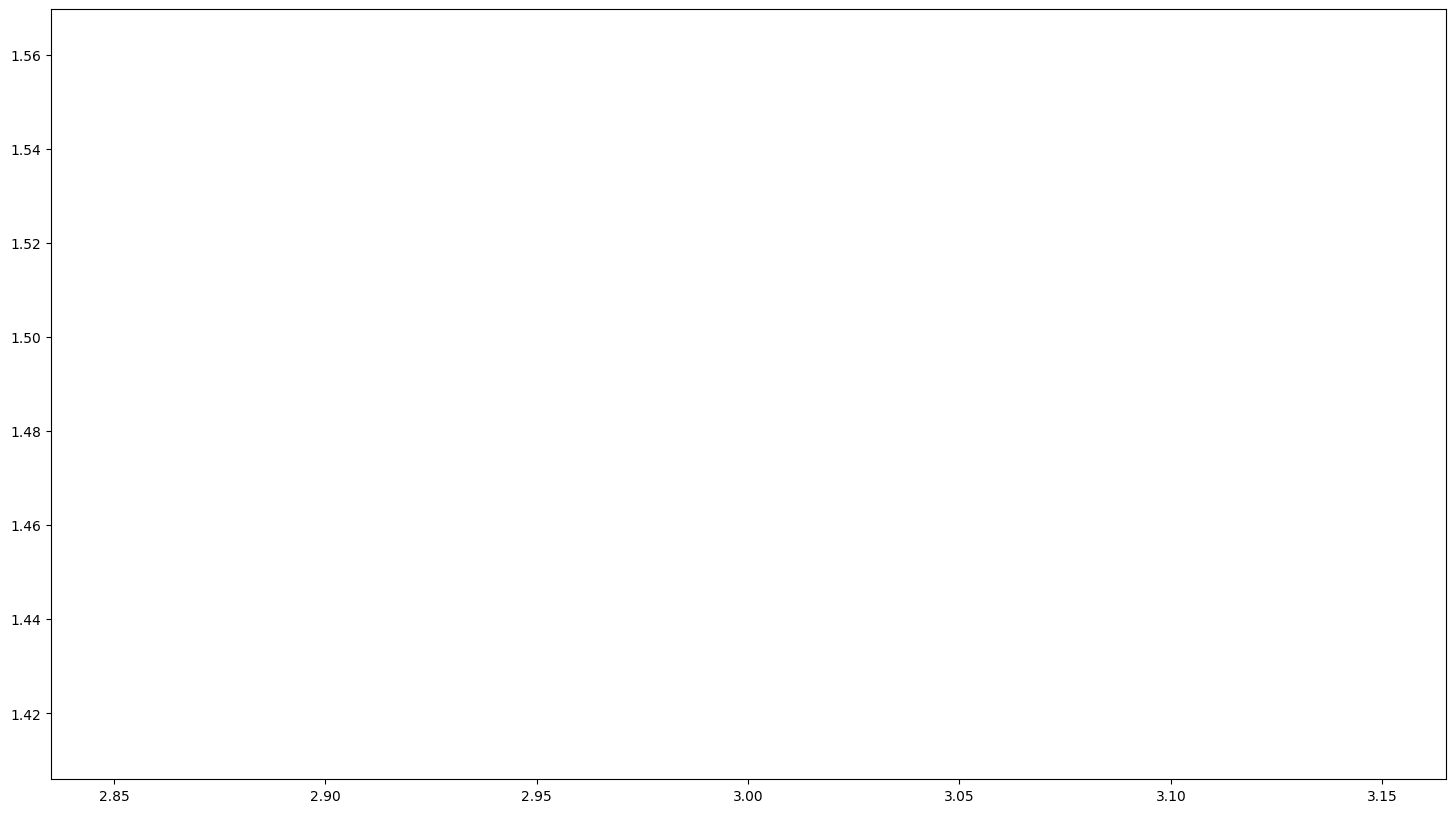

Finished running for n=103


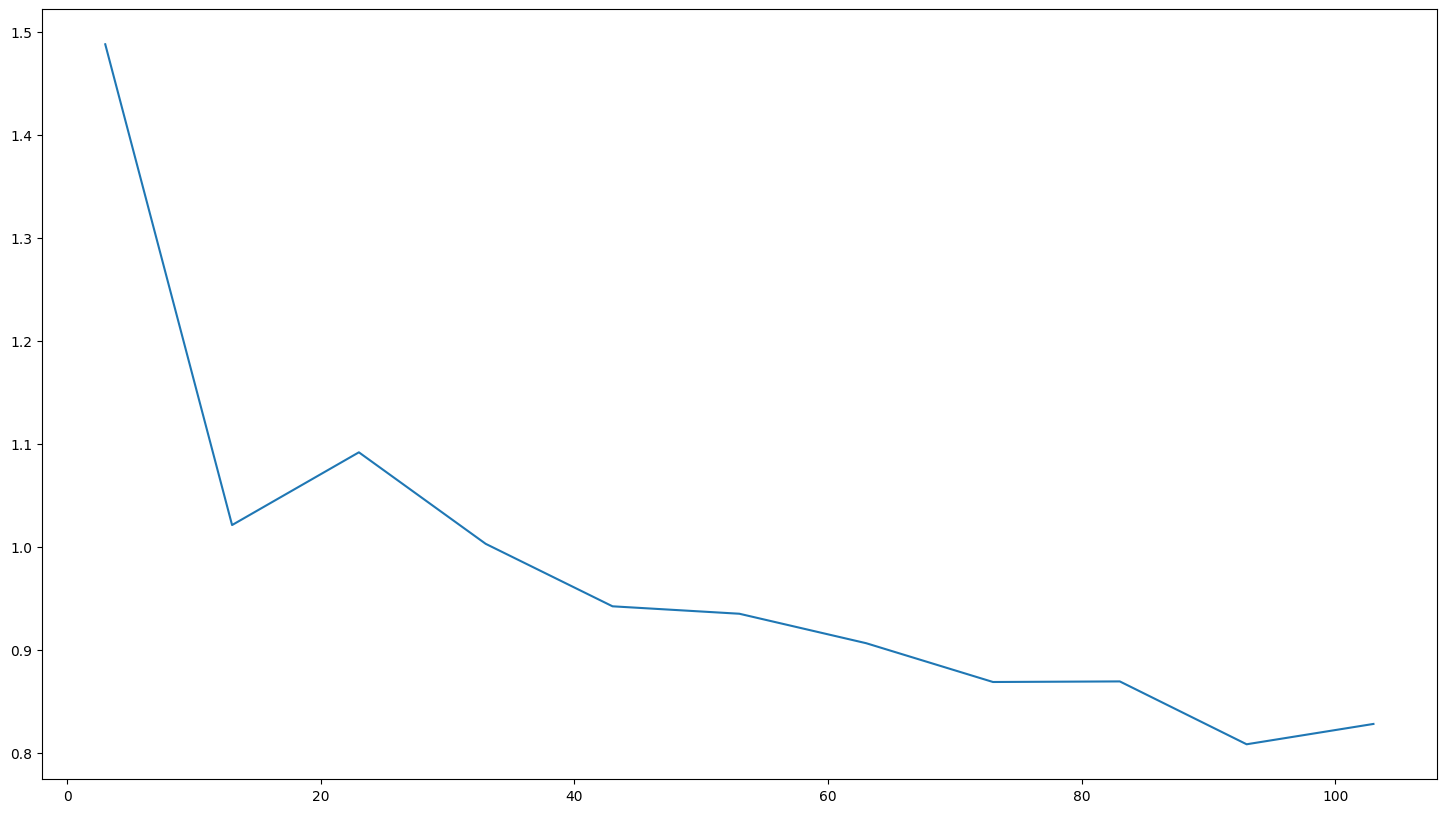

Finished running for n=203


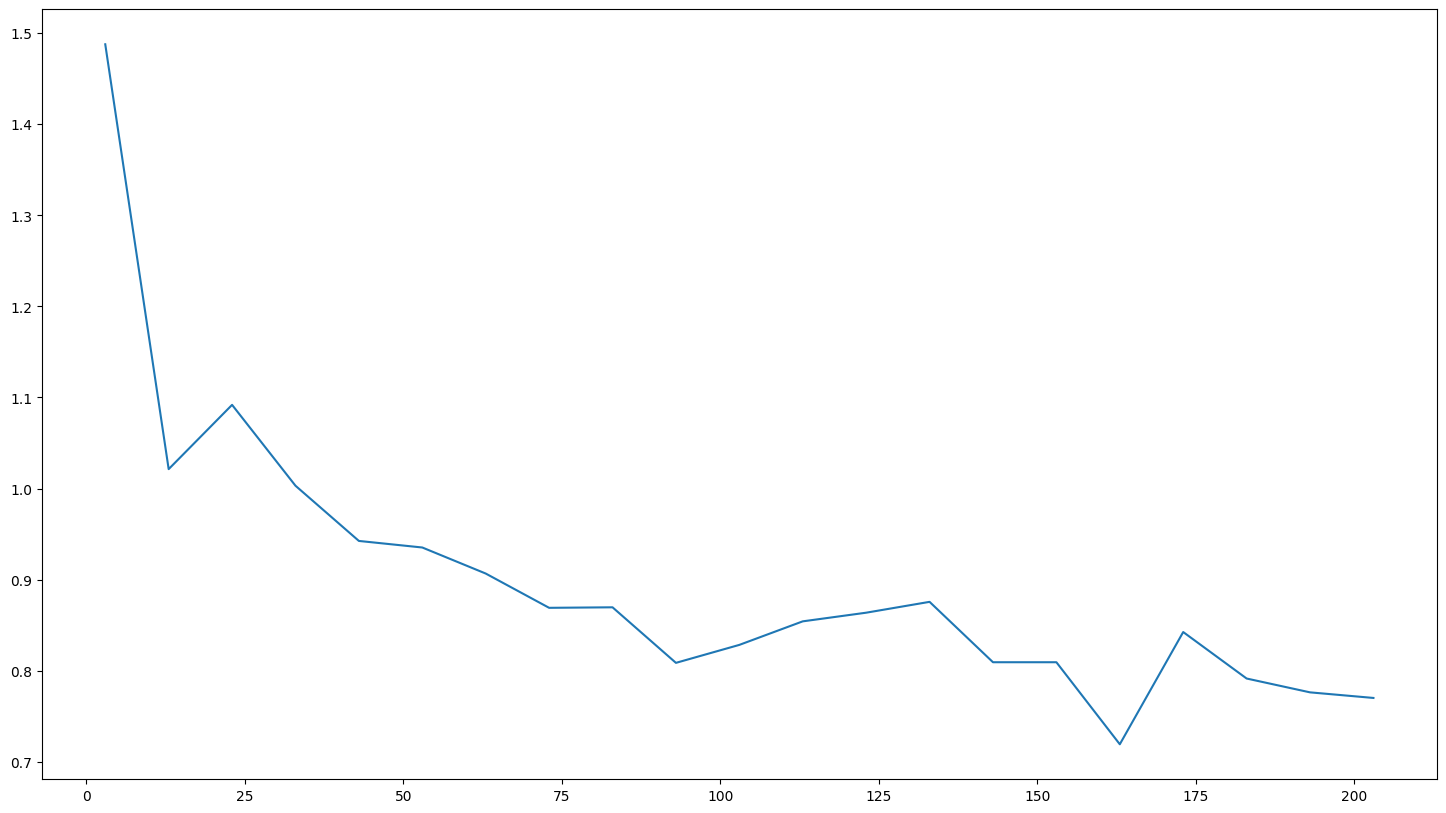

Finished running for n=303


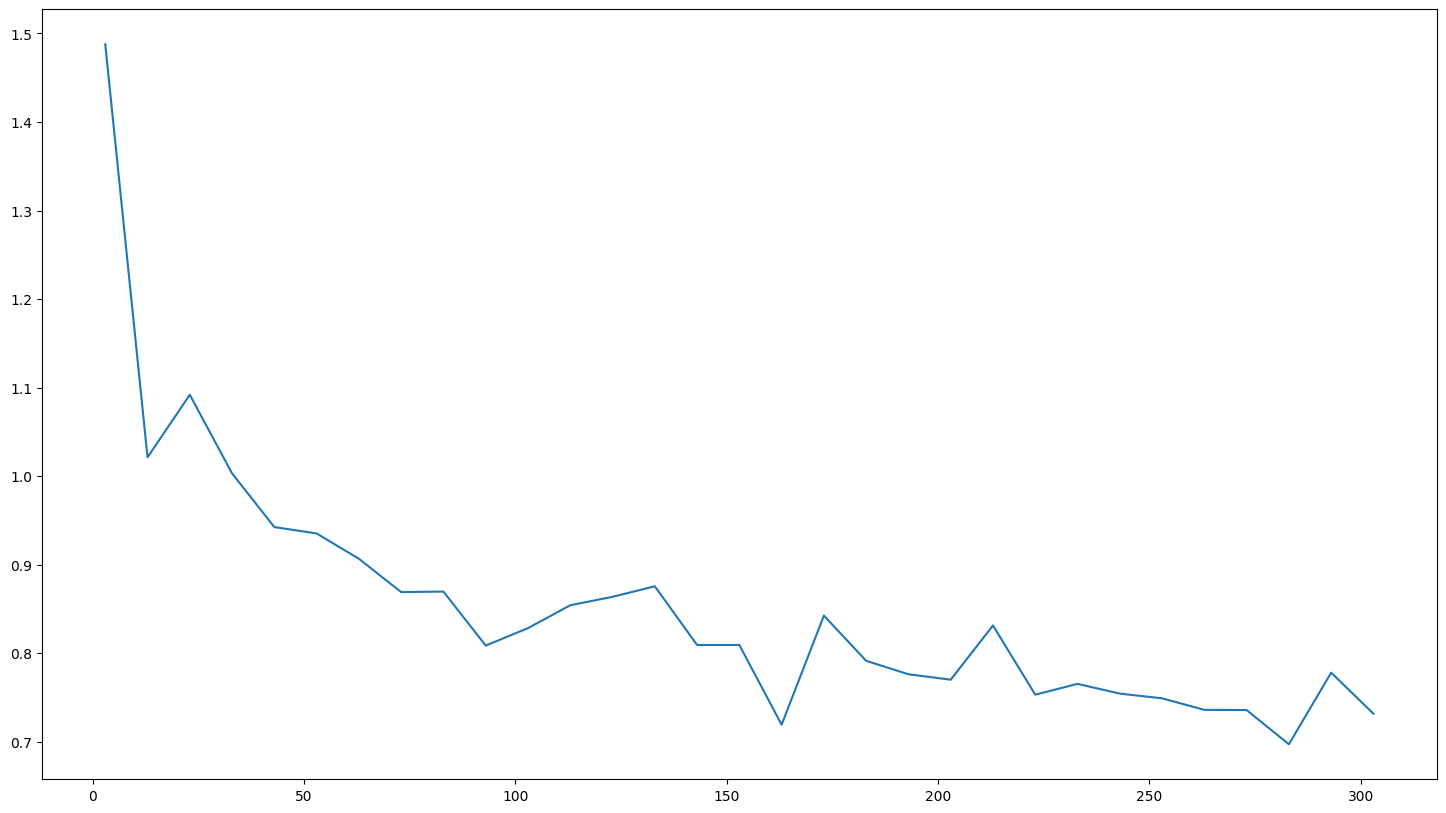

Finished running for n=403


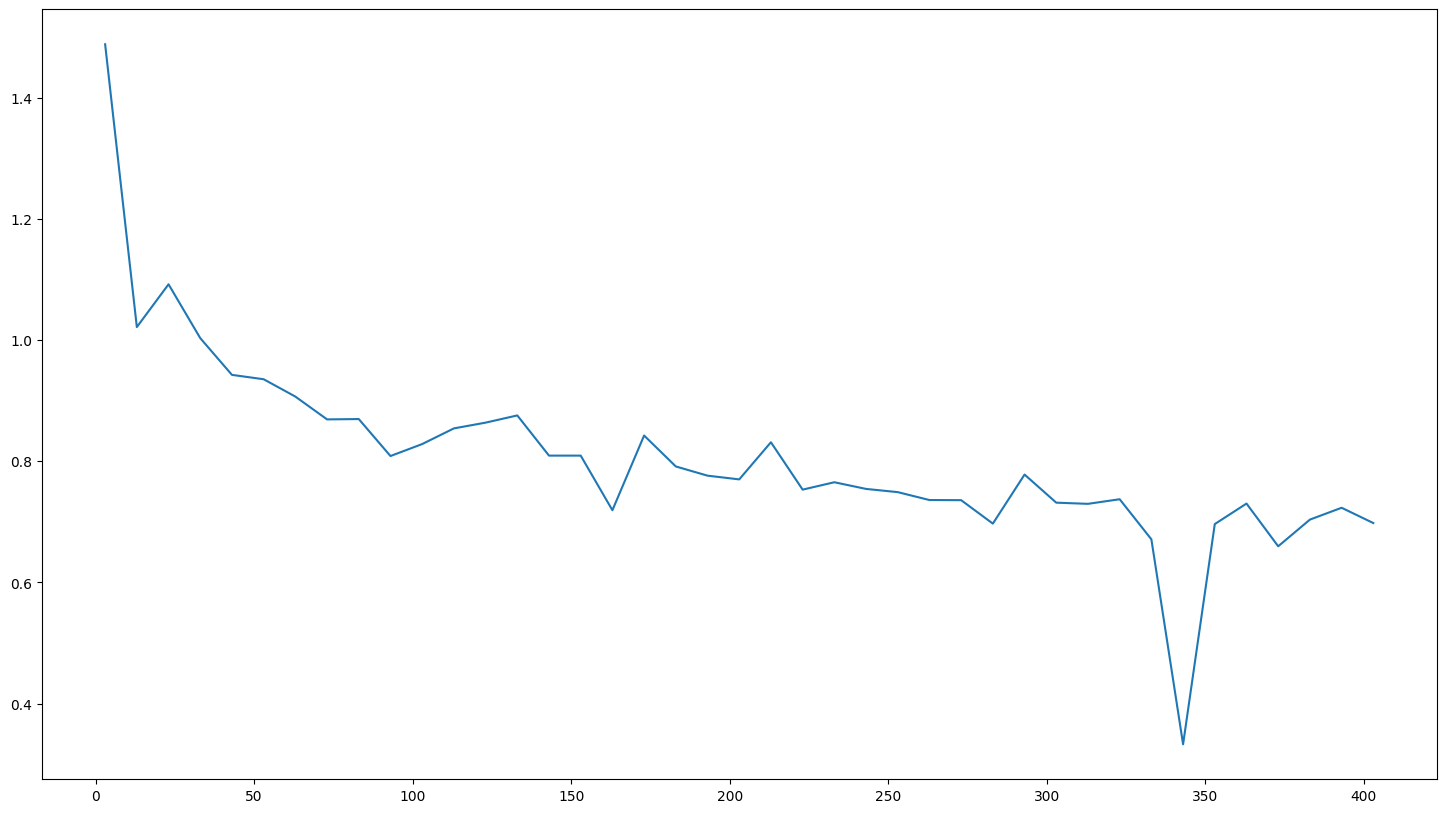

Finished running for n=503


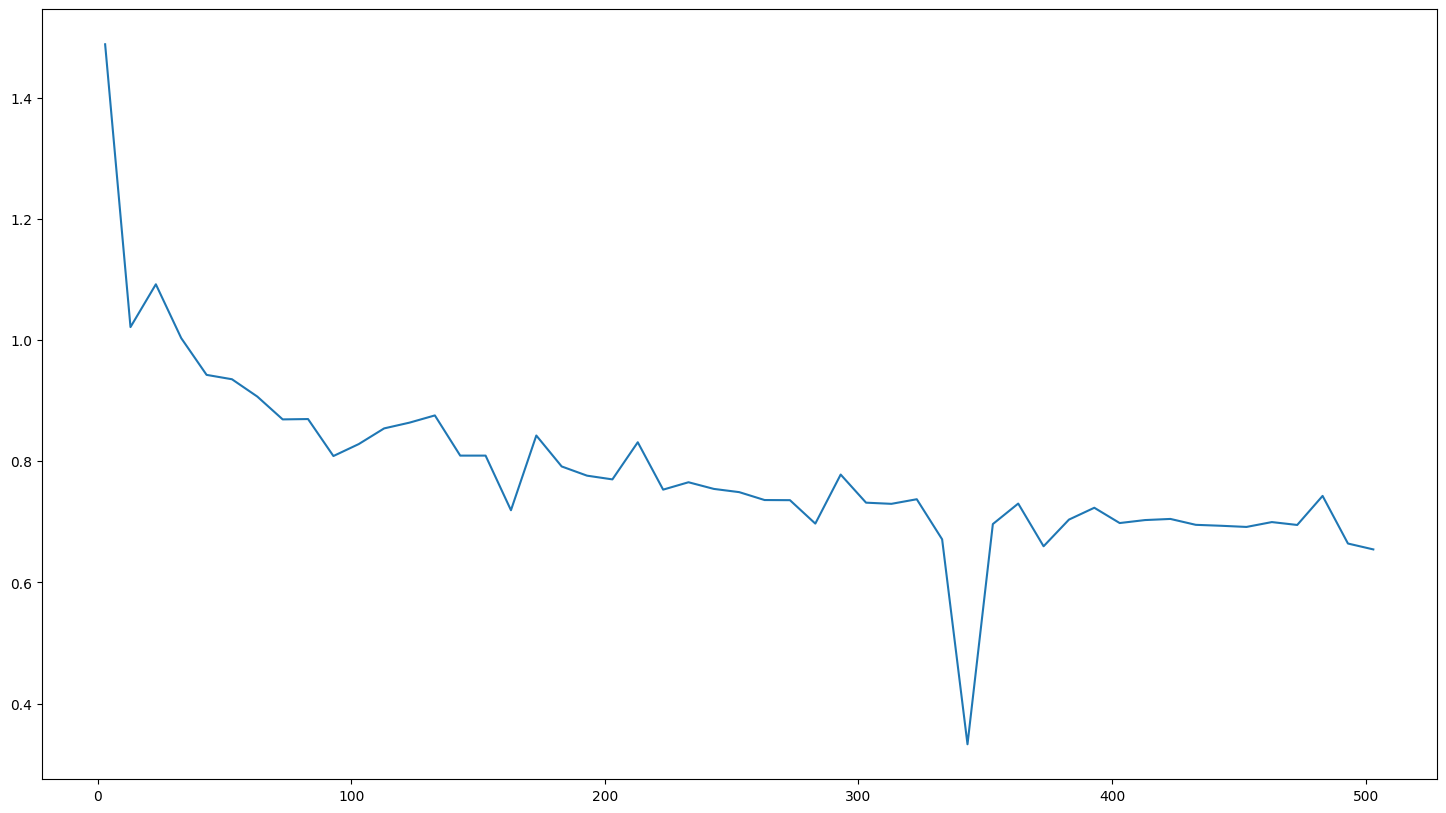

Finished running for n=603


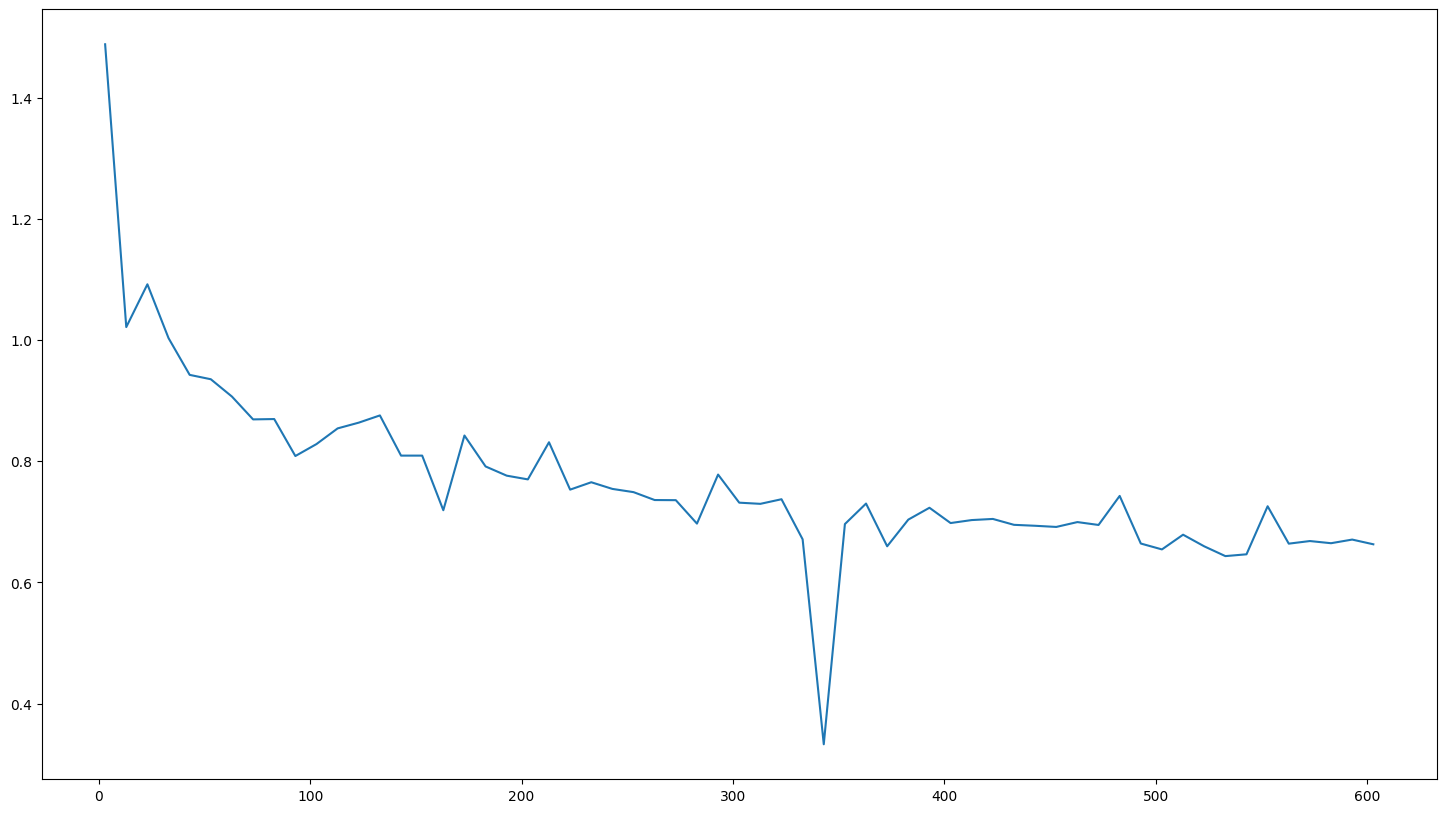

Finished running for n=703


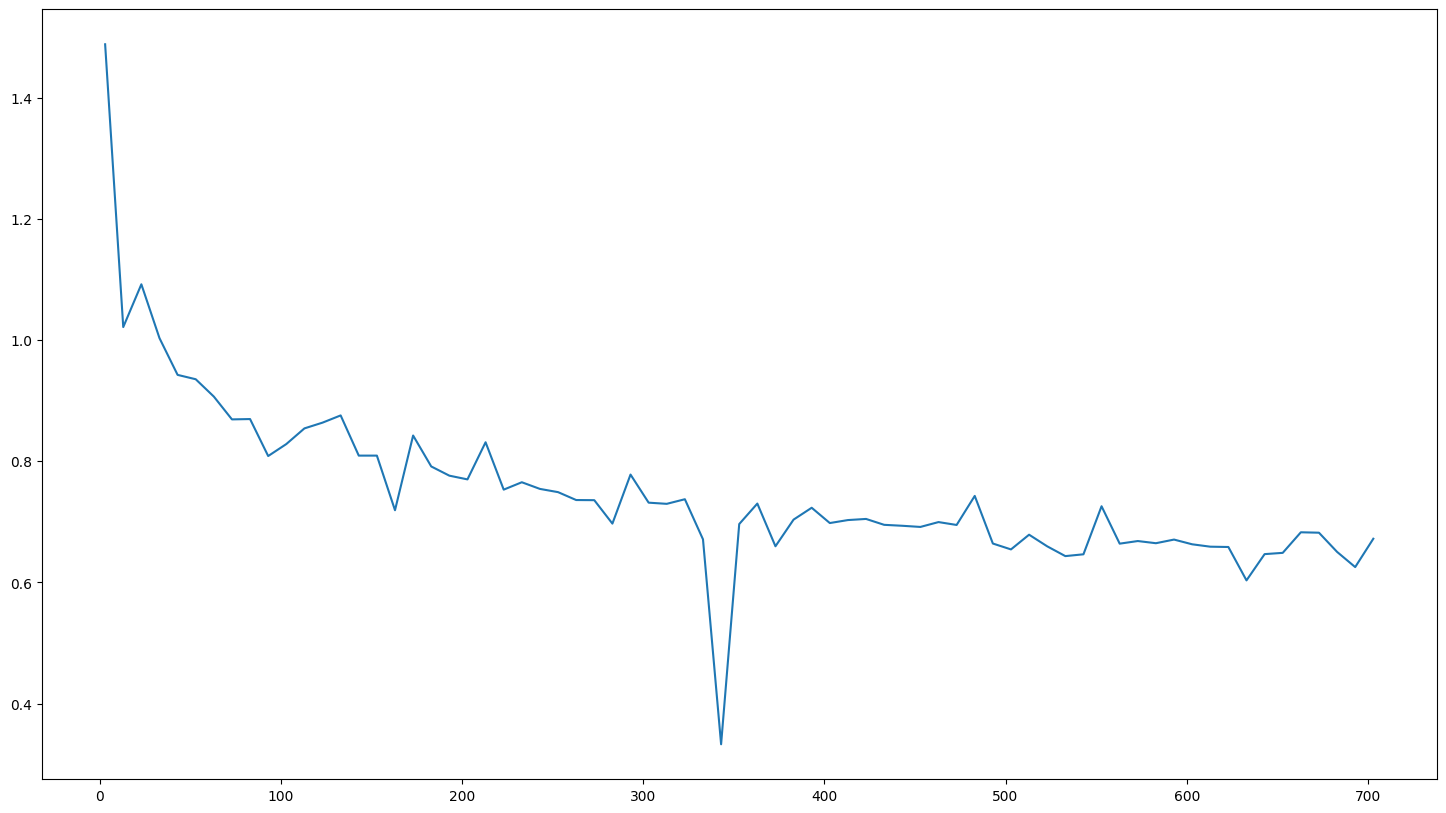

Finished running for n=803


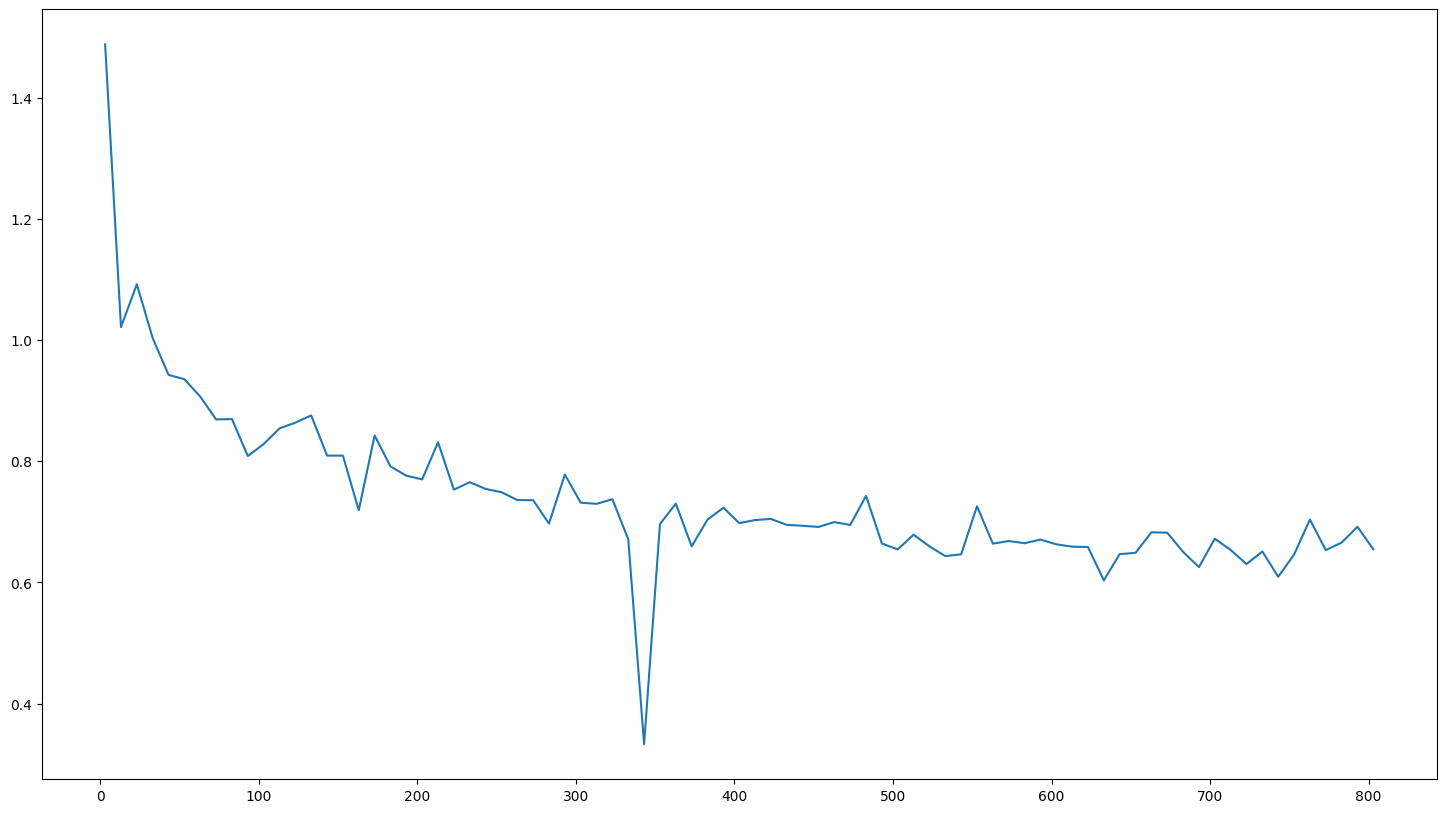

Finished running for n=903


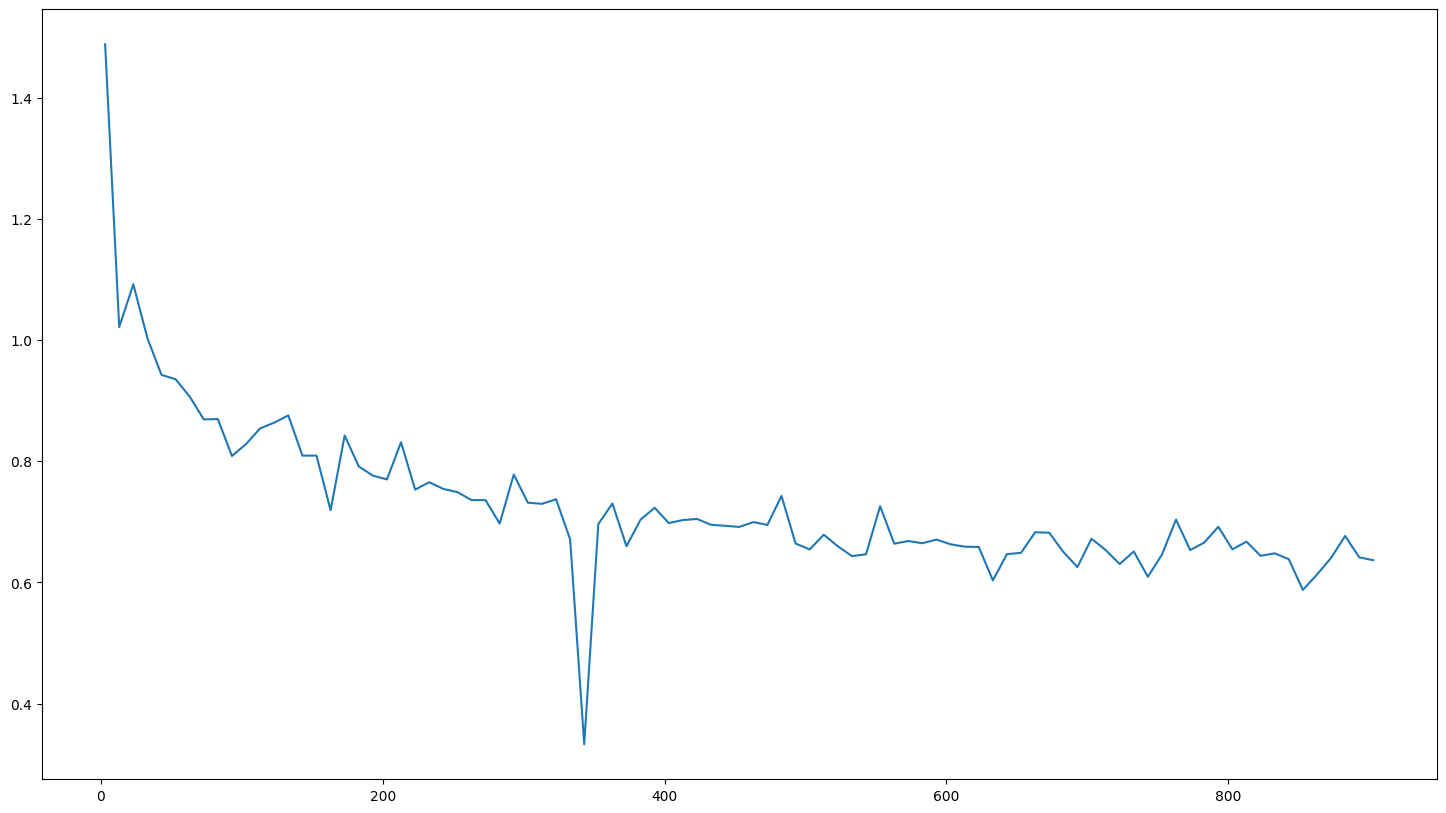

Finished running for n=1003


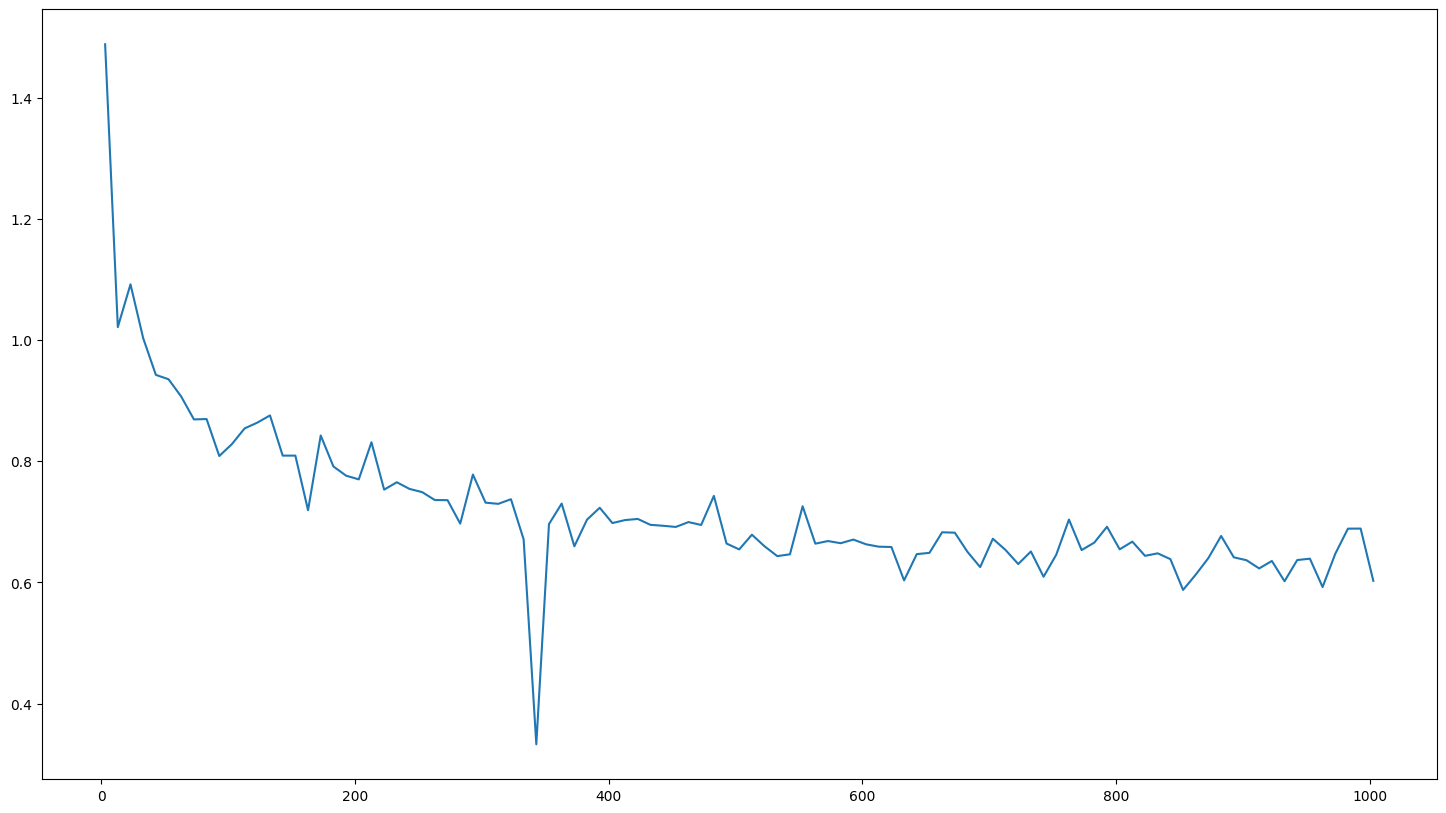

Finished running for n=5


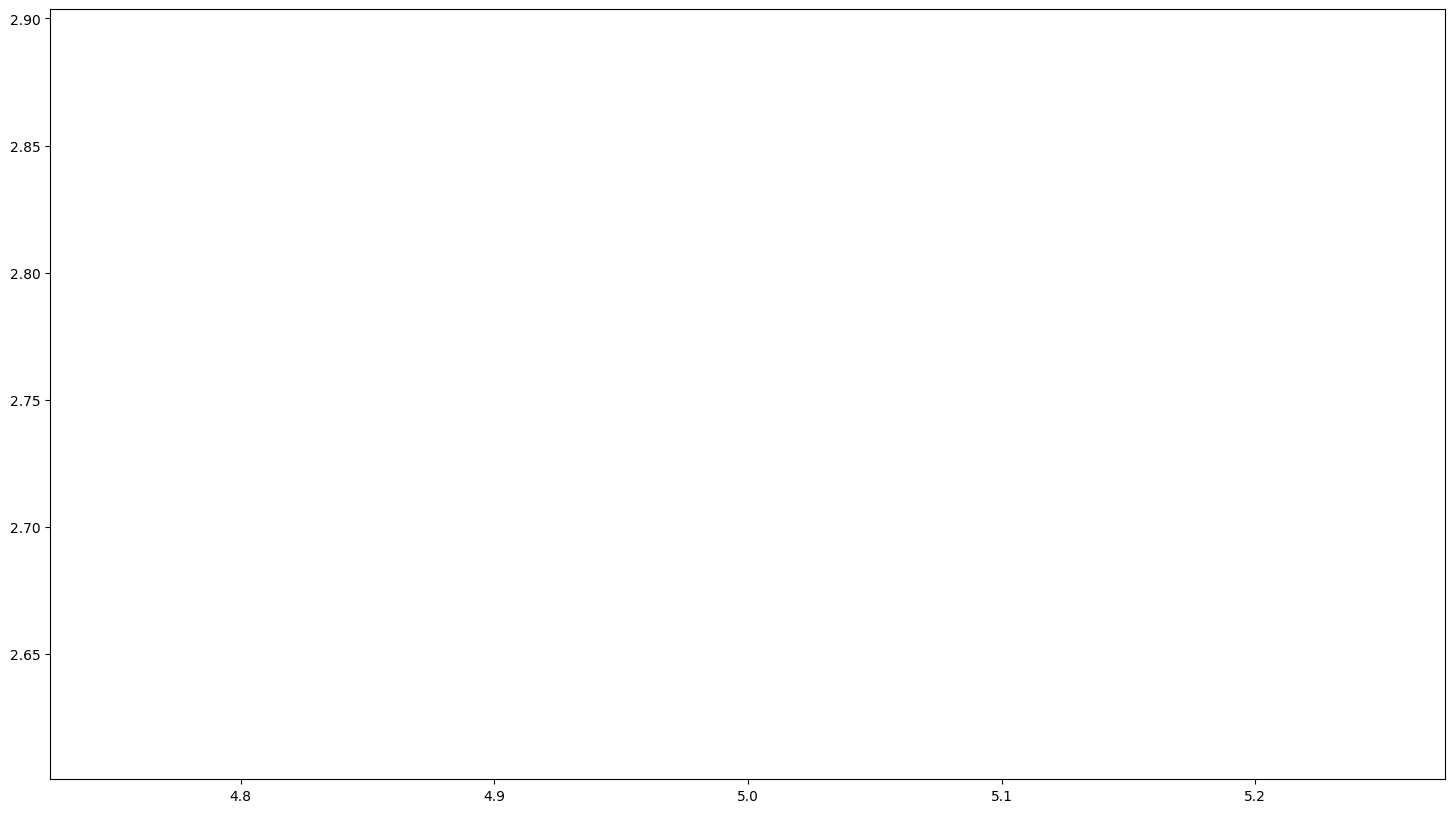

Finished running for n=105


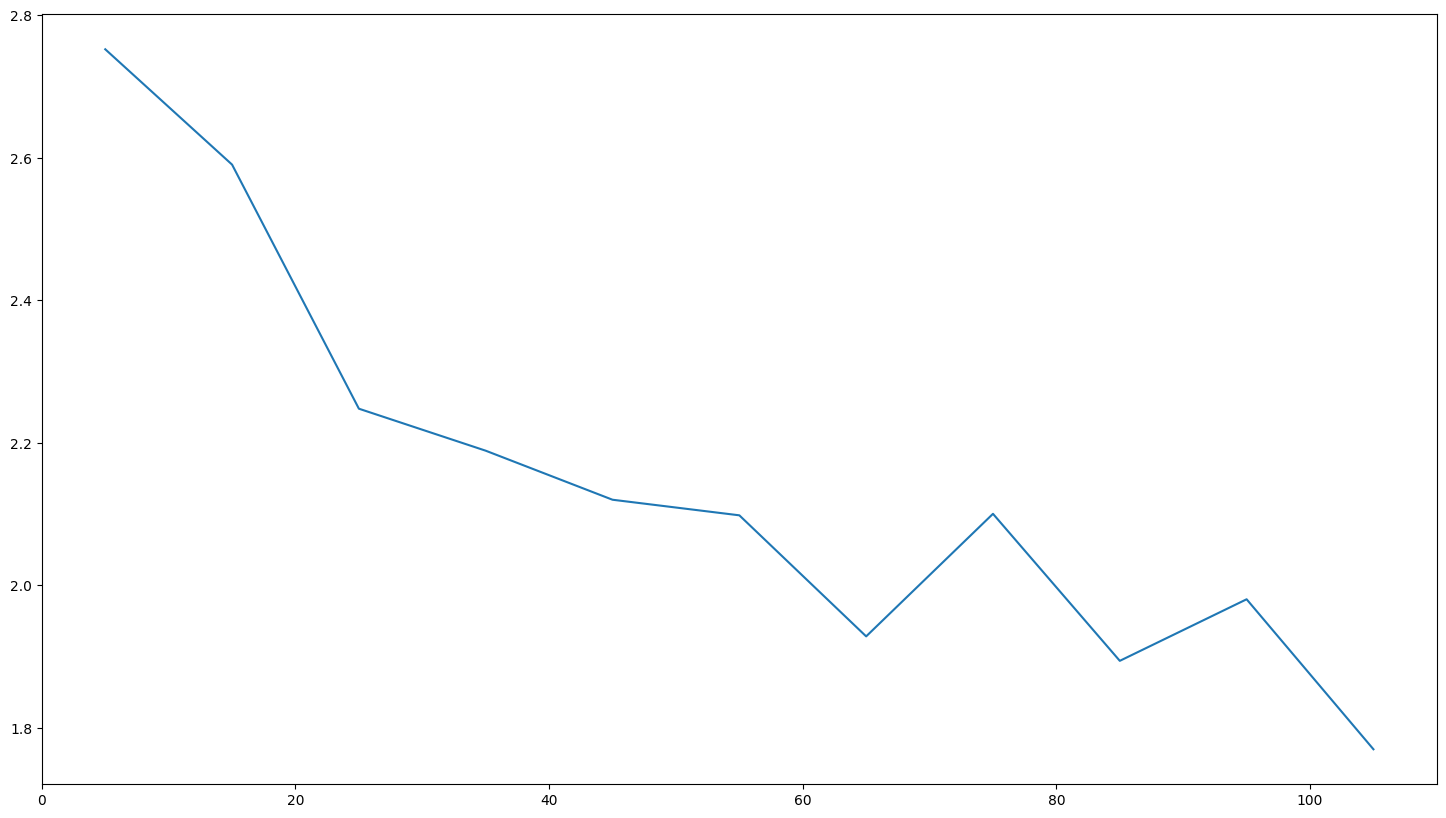

Finished running for n=205


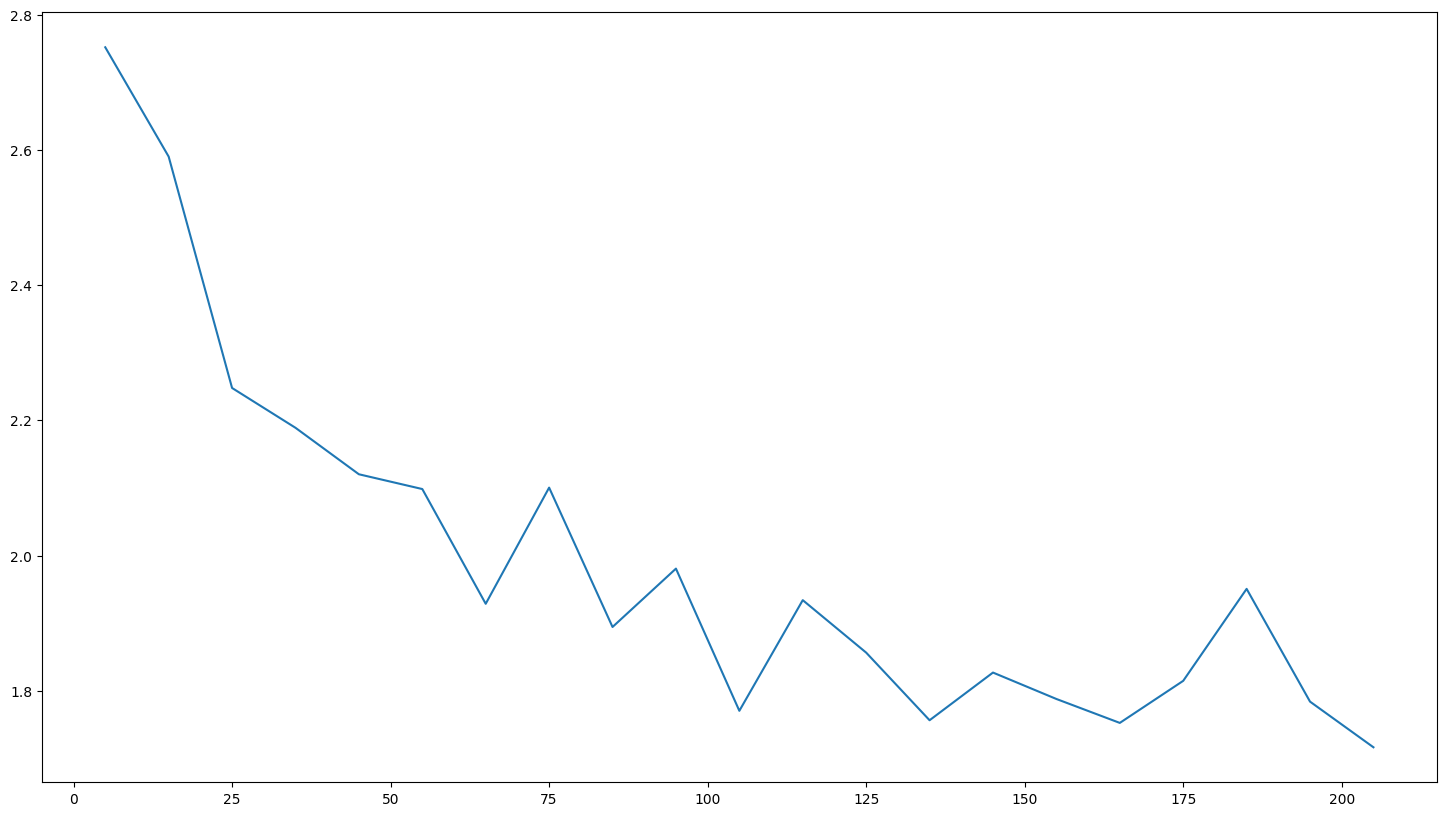

Finished running for n=305


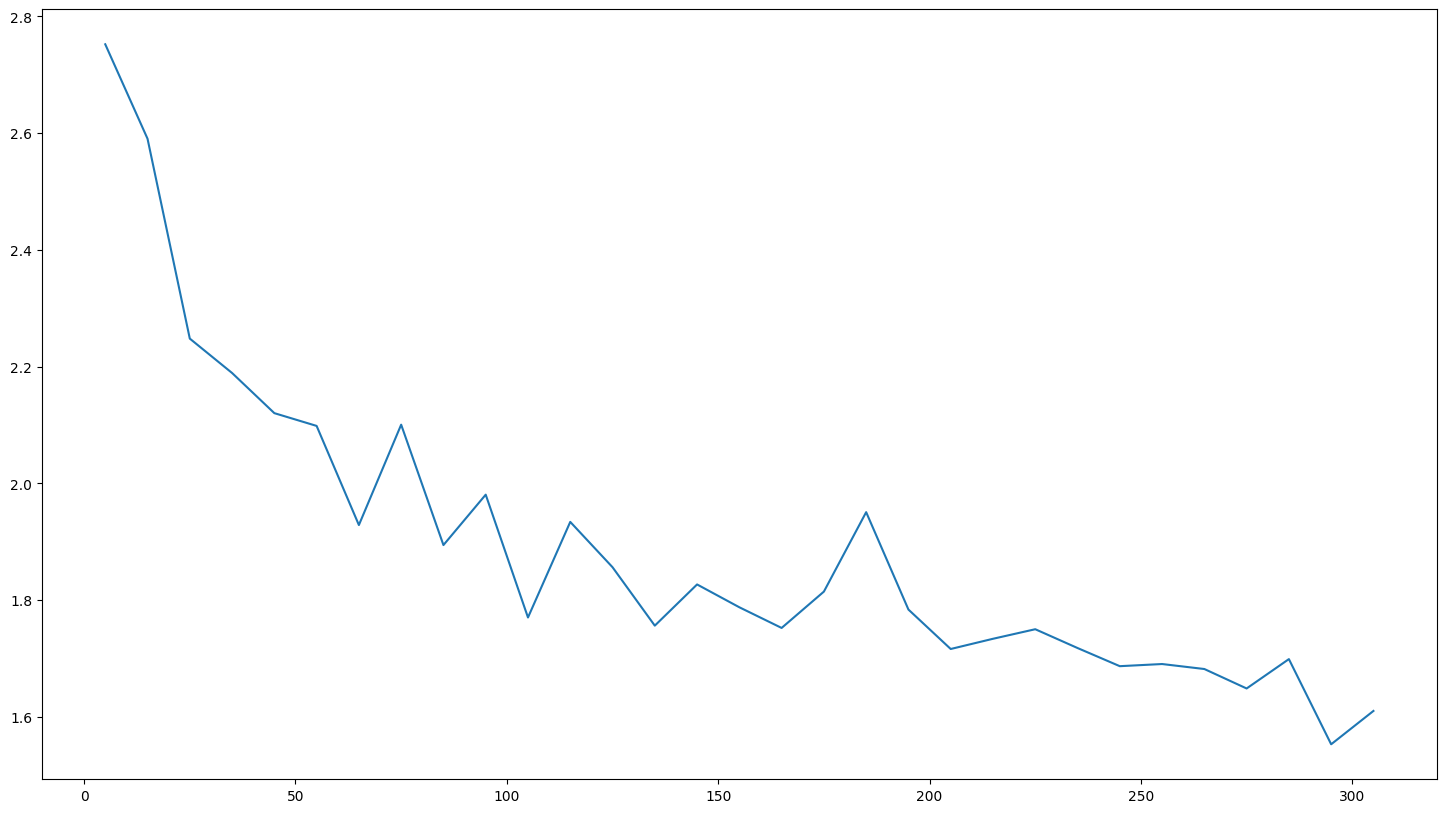

Finished running for n=405


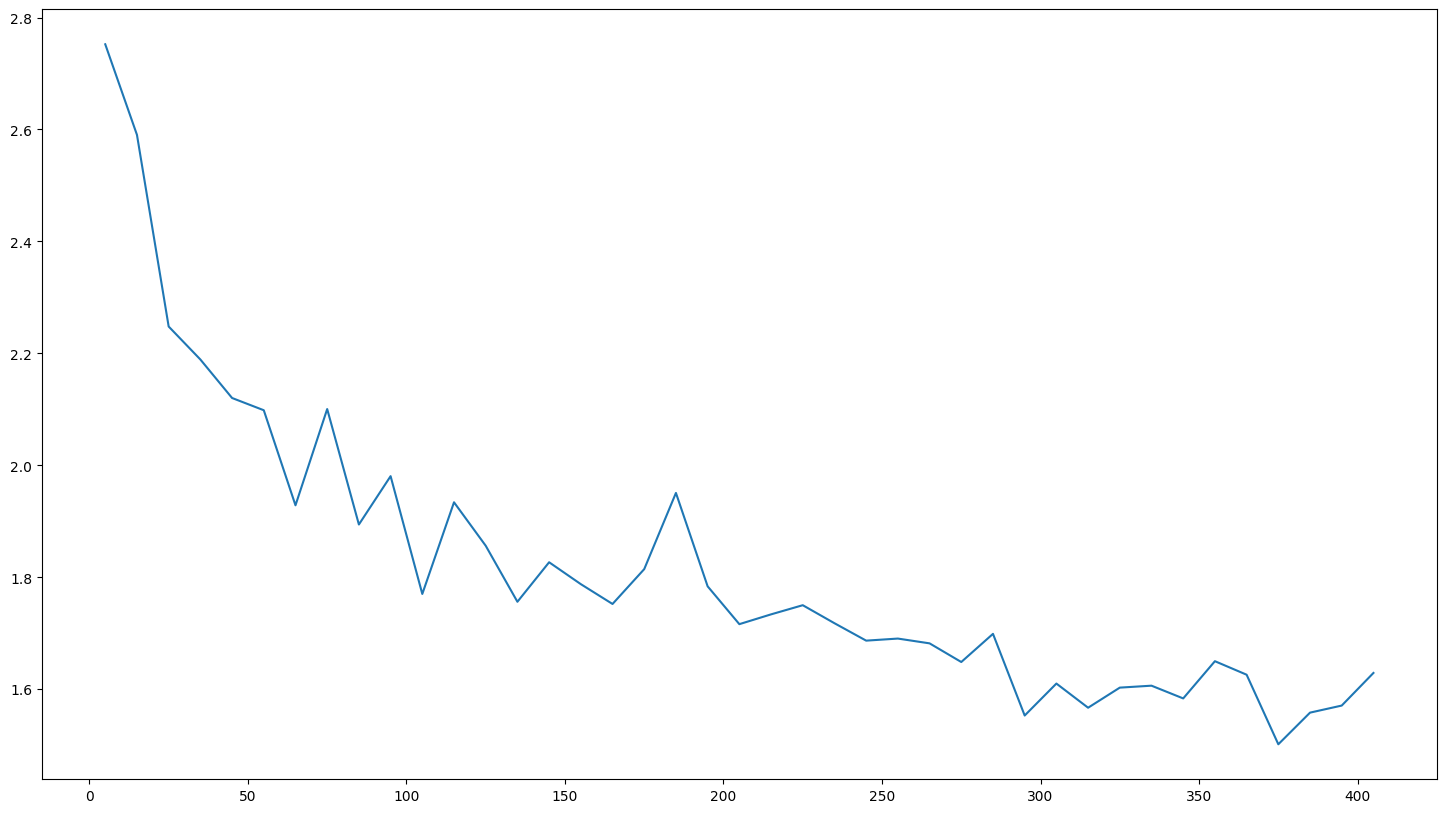

Finished running for n=505


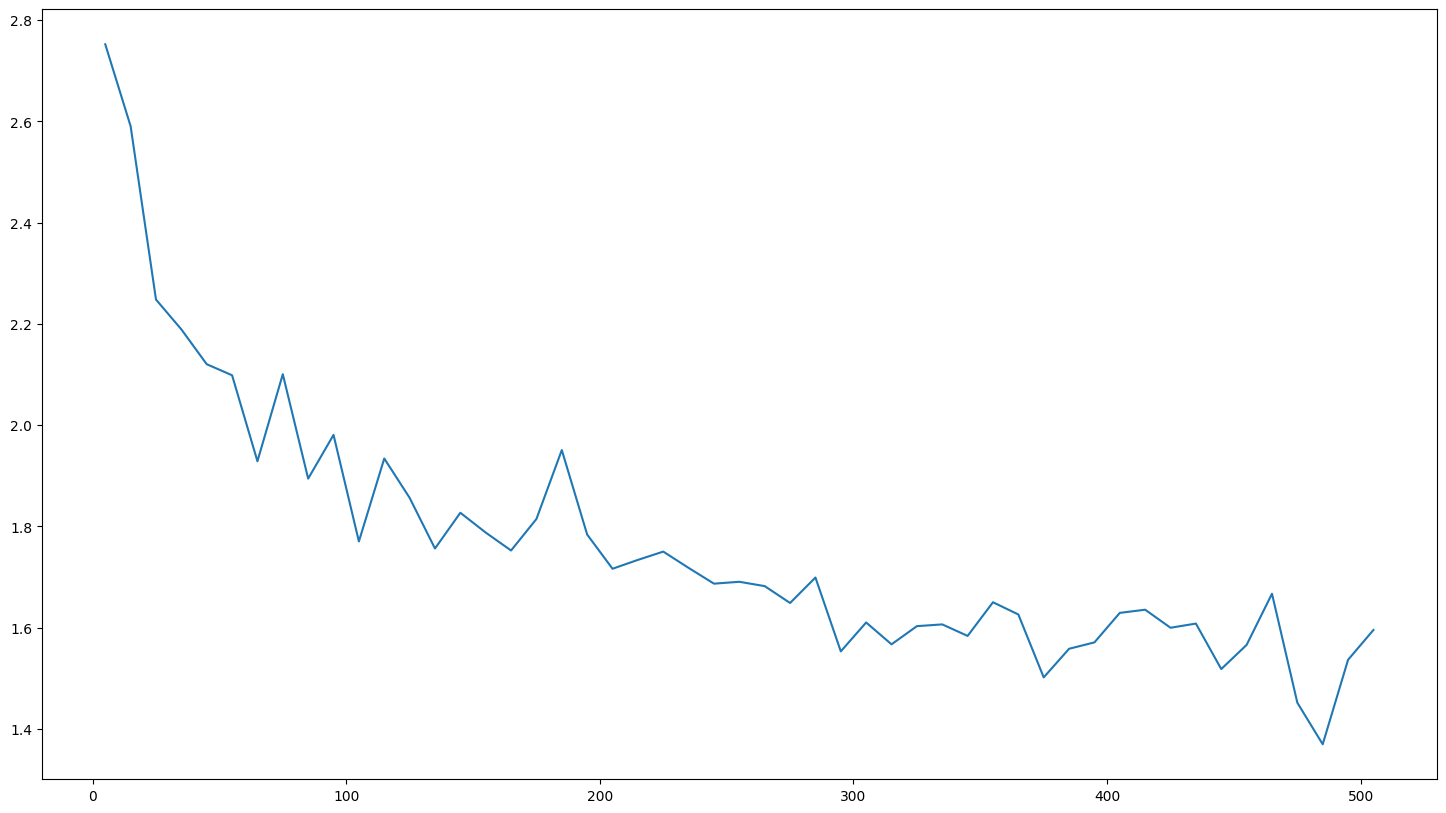

Finished running for n=605


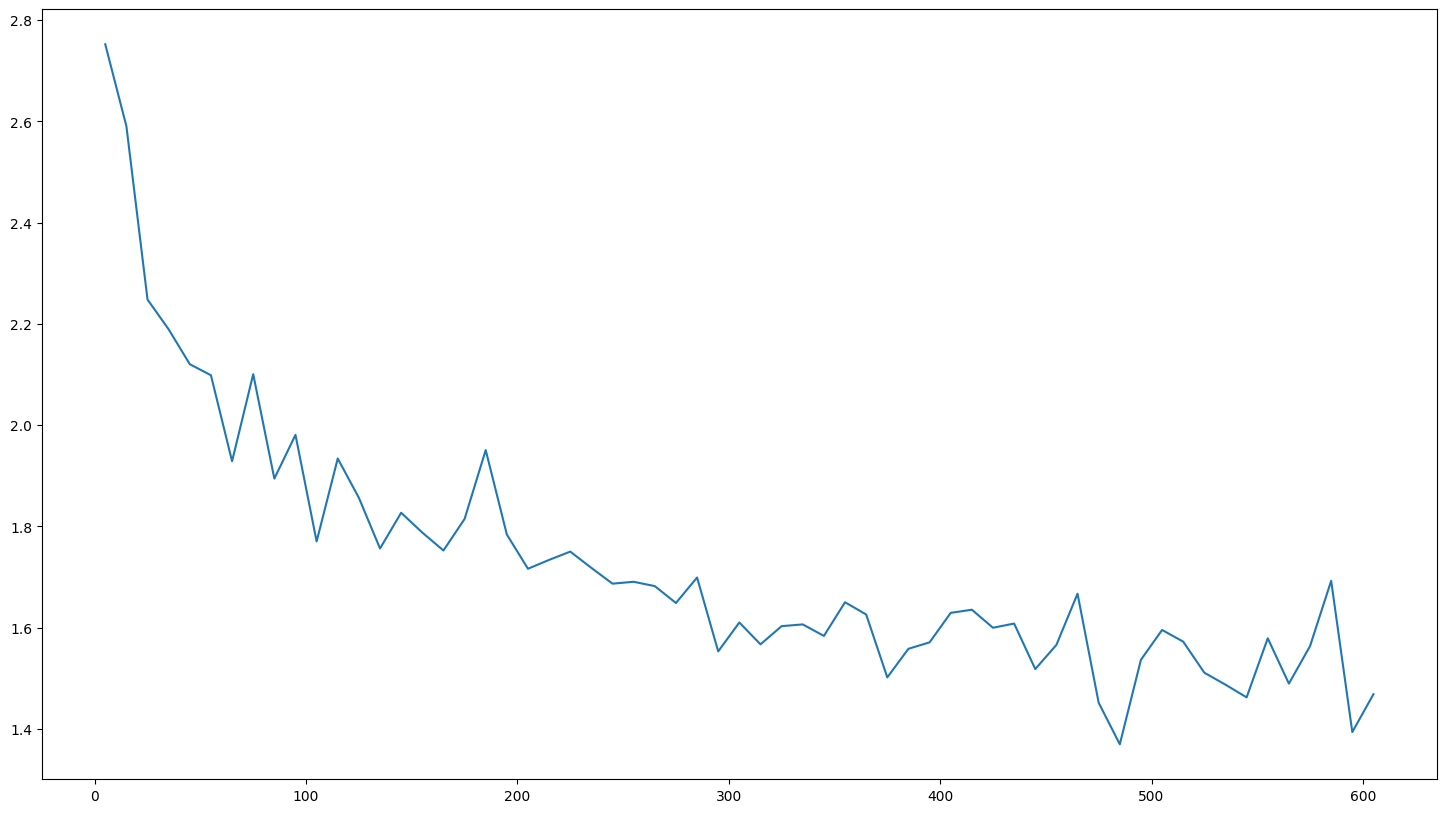

Finished running for n=705


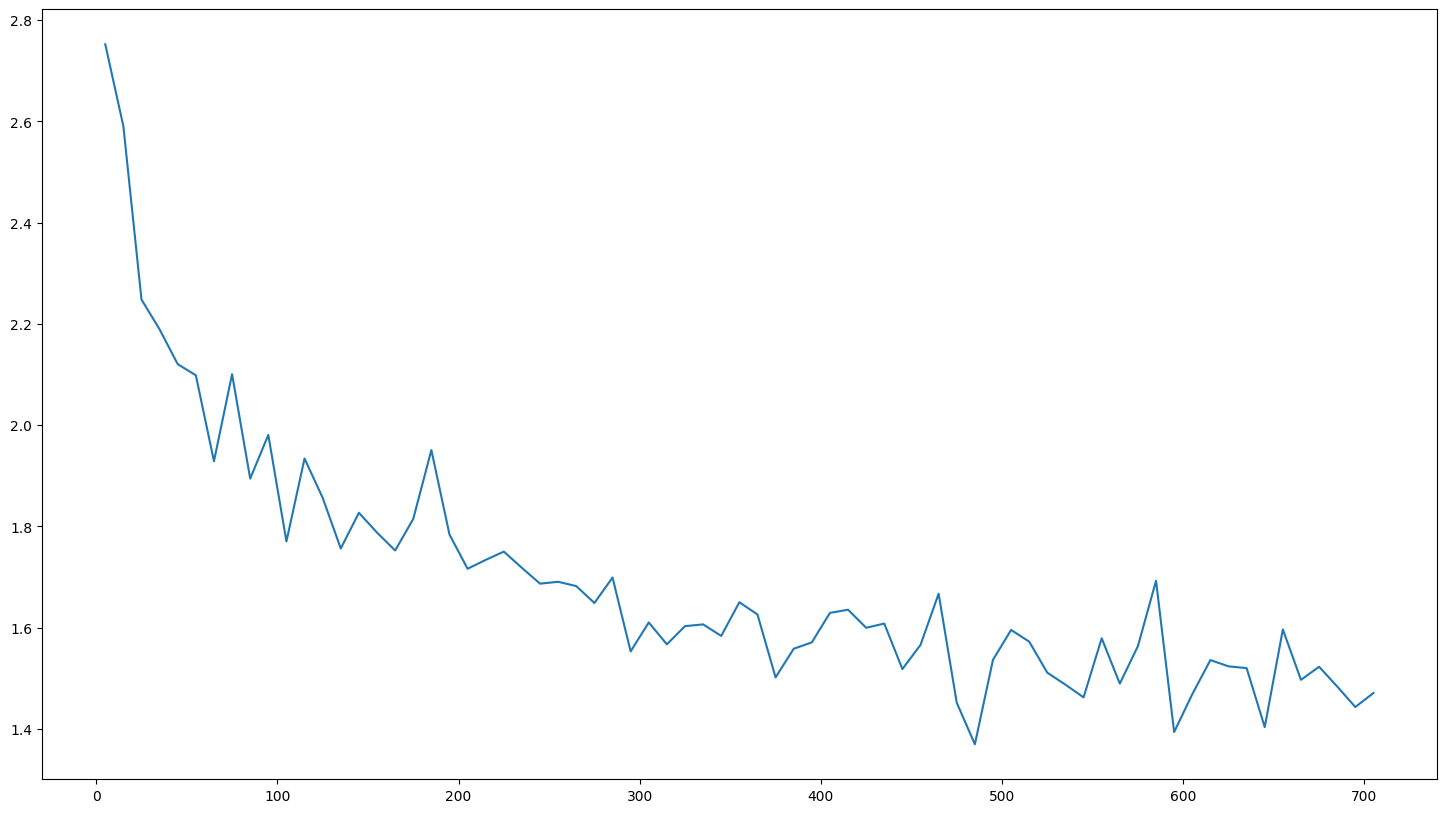

Finished running for n=805


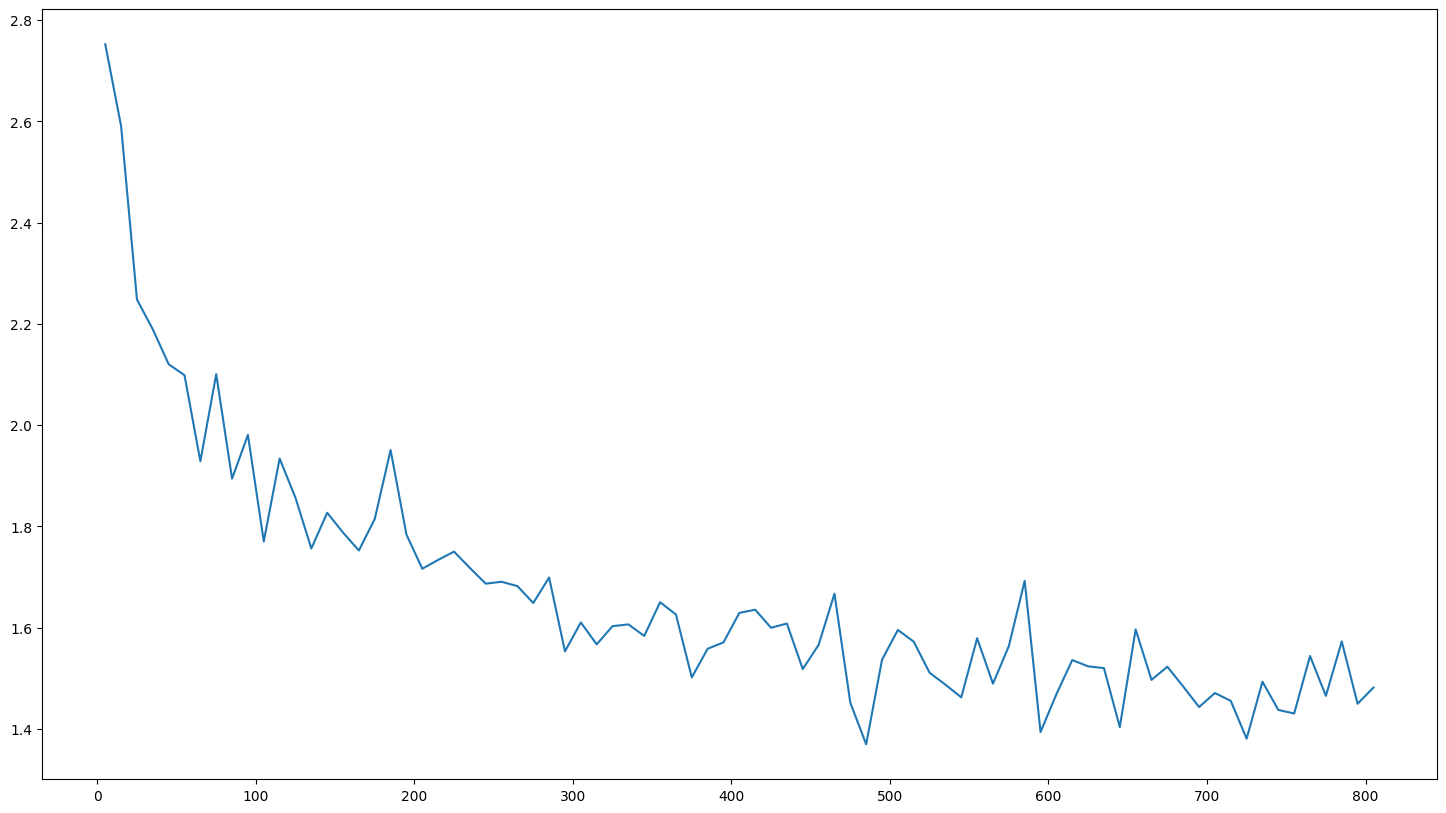

Finished running for n=905


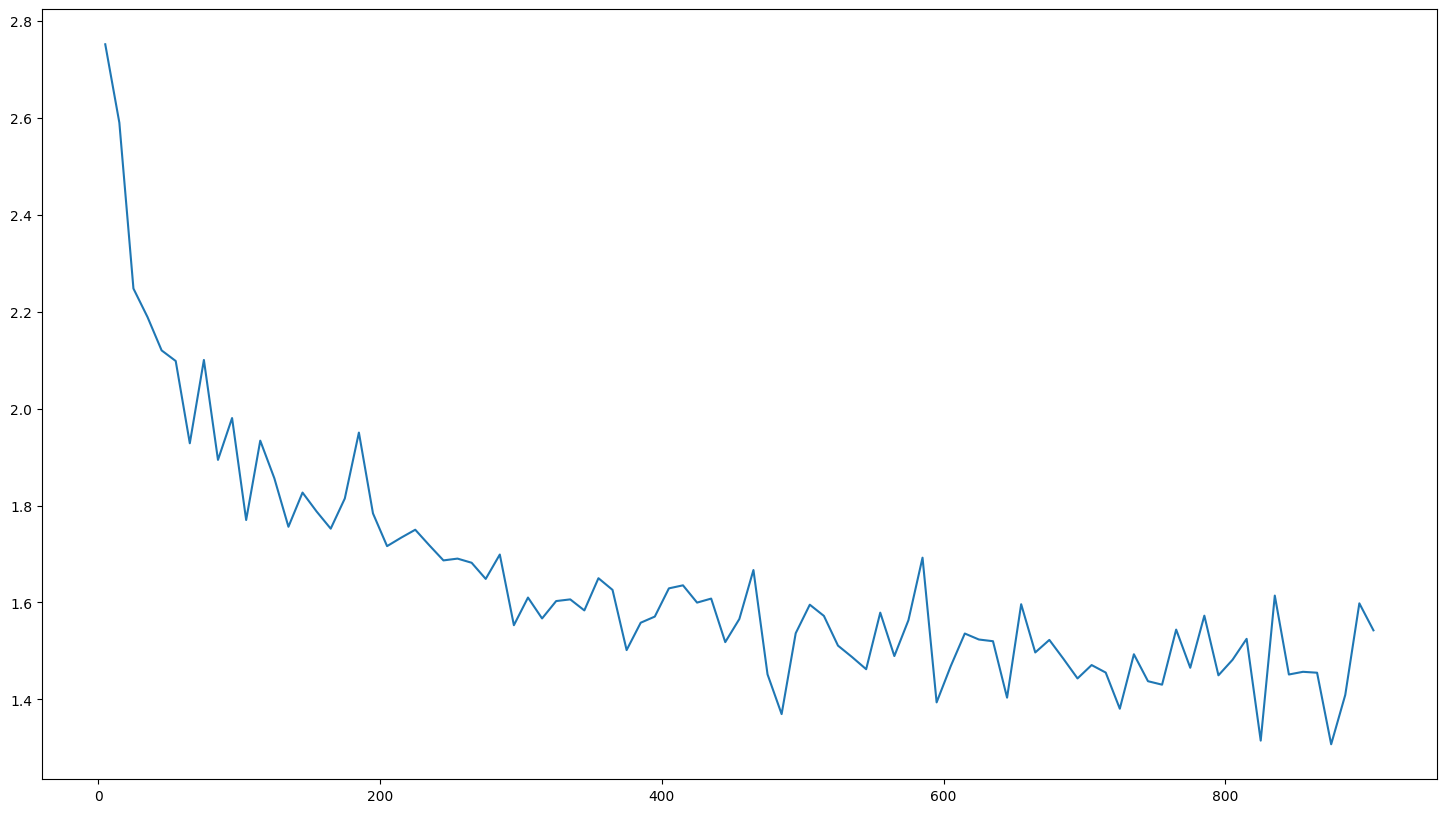

Finished running for n=1005


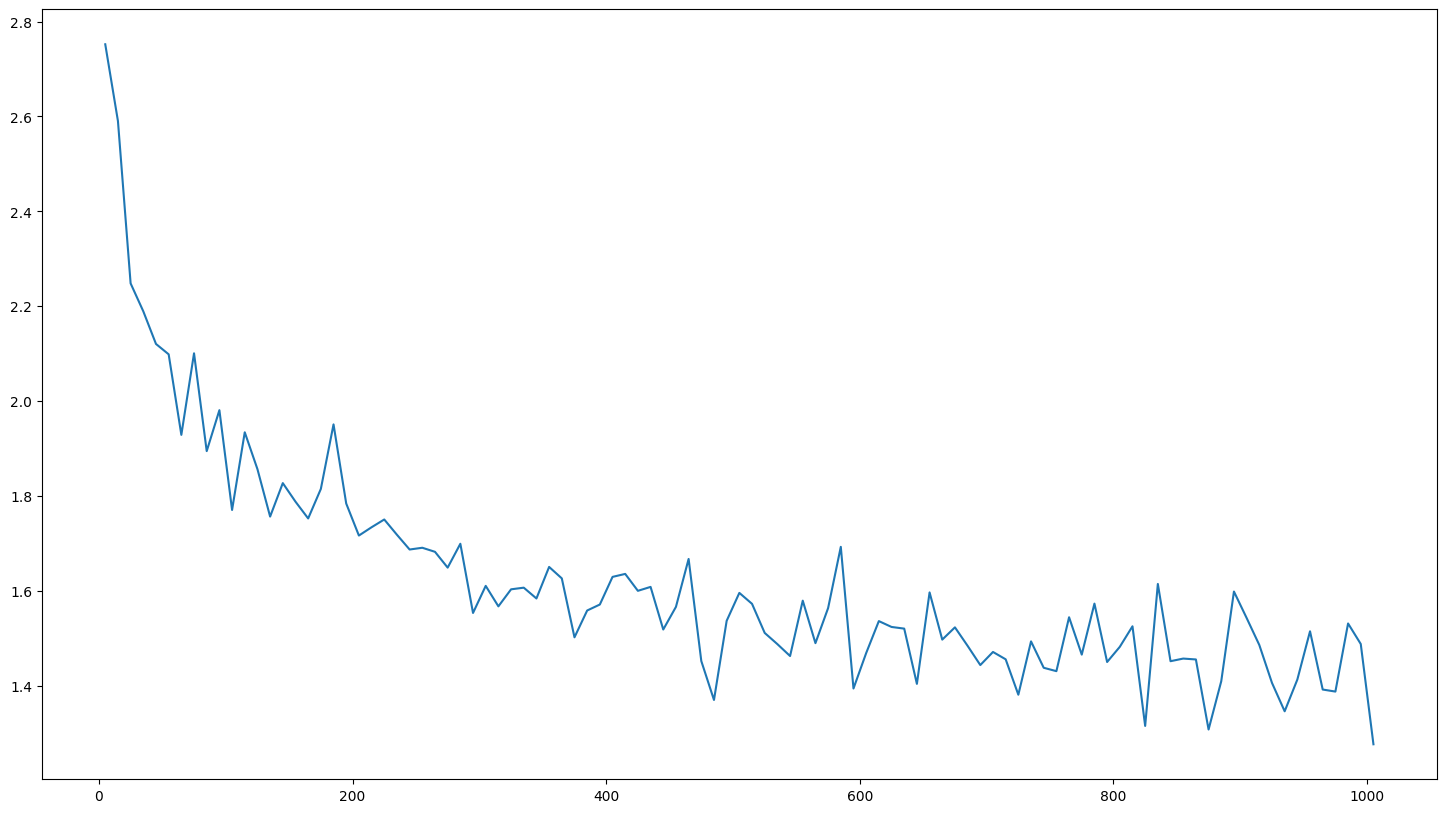

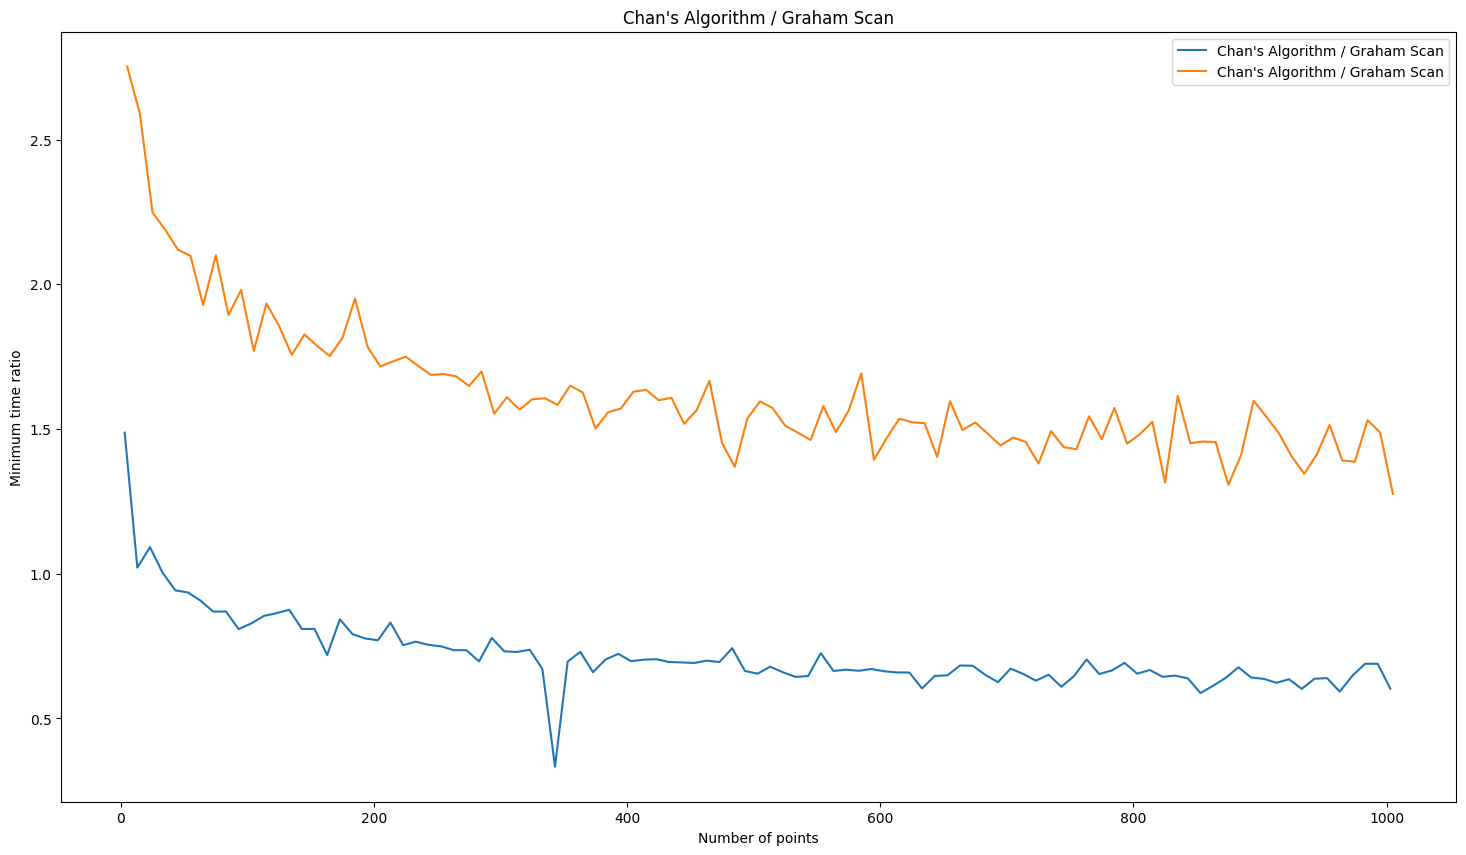

In [56]:
# Analysis to see when Chan's Algorithm is better than Graham Scan
# we fix h to multiple different values (e.g. 3, 5, 10, 20, 50, 100) and vary n

# Experiment Chan's Algorithm vs Graham Scan
chans_algorithm = "Chan's Algorithm"
graham_scan_algorithm = "Graham Scan"
hs = [3, 5] #, 10, 20, 50, 100]
experiments = []
for h in hs:
    experiment = ExperimentalFramework(f"Chan's Algorithm / Graham Scan (h={h})")
    experiment.set_independent_variable("Number of points")
    experiment.set_trials_per_run(10)

    experiment.add_algorithm(chans_algorithm, chan)
    experiment.add_algorithm(graham_scan_algorithm, graham_scan)

    start = h
    end = 1000
    step = 10
    plot_step = 100
    data_generator.set_seed(42)
    for n in range(start, end + step, step):
        input_set = data_generator.generate_points(h, n)
        experiment.run_from_input(n, input_set)

        if (n - start) % plot_step == 0:
            print(f"Finished running for n={n}")
            experiment.plot_mins()

    experiments.append(experiment)

ExperimentalFramework.plot_multiple_experiments_min_ratios(experiments, chans_algorithm, graham_scan_algorithm)